# Numerical Linear Algebra - EXAM
- Submitted by Claire SUN (3630998)
- Submission Date: 2022.02.12

**Declaration:** 

*I have prepared the assignment myself and I have only used the sources declared in comments to the program*

<br>

**[Programming Assignment Instructions](qr-method.pdf)**
  
<br>
<img src="figures/QR_Algo_1.4.14.png" width="700px"/>
Image source: Lecture Notes

In [1]:
# Import Libraries 

import numpy as np
import cmath 
import matplotlib.pyplot as plt
from scipy.linalg import hessenberg
from scipy.io import mmread

In [2]:
# Set Global Variables

MAX_ITER = 1000 # maximum number of iterations for testing
RTOL = 1e-6 # relative tolerance for convergence, i.e., when subsequent iterates are smaller than RTOL, stop iteration
ATOL = 1e-18 # same as numpy: absolute(a - b) <= (atol + rtol * absolute(b))
np.set_printoptions(precision=3, linewidth=300, suppress=True)

In [3]:
# Generate Test Data

def generate_random_matrix(dtype, n):
    if dtype == 'float':
        A = np.random.rand(n,n)
    elif dtype == 'complex':
        A = np.random.rand(n,n) + np.random.rand(n,n)*1j
    return A

RANDOM_REAL_MATRICES = []
RANDOM_COMPLEX_MATRICES = []

for n in [3,5,10]:
    A = generate_random_matrix(dtype='float', n=n)
    RANDOM_REAL_MATRICES.append(A)

    A_ = generate_random_matrix(dtype='complex', n=n)
    RANDOM_COMPLEX_MATRICES.append(A_)

# symmetric real
A = np.random.randint(-3,3,(10,10))
A = (A.T + A).astype('float')

# diagonal dominant
B = A - np.triu(A,1)*0.99 - np.tril(A,-1)*0.99 

# unbalanced
C = np.tril(np.ones((10,10),dtype='float'),0)

# Numerical example from https://people.inf.ethz.ch/arbenz/ewp/Lnotes/chapter4.pdf p.81 4.5.1
# Eigenvalues = {1 ± 2i, 3, 4, 5 ± 6i}

D = np.array([[7, 3, 4, -11, -9, -2],
              [-6, 4, -5, 7, 1, 12],
              [-1, -9, 2, 2, 9, 1],
              [-8, 0, -1, 5, 0, 8],
              [-4, 3, -5, 7, 2, 10],
              [6, 1, 4, -11, -7, -1]], dtype='float')

SPECIAL_REAL_MATRICES = [A, B, C, D]

<br>

## Householder Transformation to Upper Hessenberg

<br>

**Similarity Transformation**

Two matrices  $A$  and  $B$  are similar if there exists an *invertible* matrix  $S$  such that  $A = S^{-1} B  S$. 

Similar matrices have the same eigenvalues.
Proof:
$Av = \lambda v  ⇔ B(S^{−1}v) = \lambda (S^{−1}v)  $.

If $S$ can be chosen to be a unitary matrix then $A$ and $B$ are *unitarily equivalent*. 

Similarity transformation to Hessenberg form preserves eigenvalues.

The iterates  $A_0,A_1,… $ from the QR algorithm are also similar matrices since $A_{k+1} = R_k Q_k = Q^{−1}_k (Q_k R_k) Q_k = Q^{−1}_k A_k Q_k$. Therefore, $A_0,A1,…,$  have the same eigenvalues.

<br>
<br>

**Householder Reflector**

<img src="figures/HouseholderReflector1.png" width="300px"/>

*Image source: https://www.cs.utexas.edu/users/flame/laff/alaff/chapter03-householder-transformation.html*

<br>
<br>

**Hessenberg Reduction**

<img src="figures/Hessenberg.png" />

*Modified based on image source: https://www3.math.tu-berlin.de/Vorlesungen/SoSe11/NumMath2/Materials/hessenberg_eng.pdf*

<br>

In [42]:
def Householder(a):
    
    """     Compute the Householder refelector H for a given vector a
            H = I - 2 u @ u.T ;  a' = H @ a
    Input   -------------------------------------------------------- 
            a: 1D np.array with real or complex entries, size n
    Return  --------------------------------------------------------
            H: 2D np.array with real or complex entries, size nxn
    """ 
    
#    Initial try: naive implementation for real vectors

#    n = len(a)
#    e = np.zeros(n)
#    e[0] = np.sign(a[0])
#    v = a + np.linalg.norm(a,2) * e
#    H = np.eye(n) - 2* np.outer(v,v) / np.dot(v,v)

    
#   Improved version: for both real and complex vectors; element update rather than entire vector 

    n = len(a)
    v = a.copy()
    
    if np.sign(a[0]) >= 0: #sign of the first element to avoid cancellation
        sign = 1
    else:
        sign = -1

    # for real matrix: v @ v.T (transpose) 
    
    if a.dtype != 'complex': 
        v[0] = a[0] + sign * np.linalg.norm(a,2)
        if np.linalg.norm(v,2)!= 0:
            u = v / np.linalg.norm(v,2)
        else:
            u = v
        H = np.eye(n) - 2 * np.outer(u,u)

        
    # for complex matrix: v @ v.conjugate.T, phase cancellation so that the first subdiagonal element should be real 
    # (Source: https://arxiv.org/pdf/math-ph/0609050.pdf p.19)
    
    else: # a.dtype == 'complex':
        
        theta = cmath.phase(a[0])
        v[0] = a[0] + sign * np.linalg.norm(a,2) * np.exp(theta*1j)

        if np.linalg.norm(v,2)!= 0:
            u = v / np.linalg.norm(v,2)
        else:
            u = v
        
        H = np.exp(-theta*1j)*(np.eye(n) - 2* np.outer(u,u.conjugate()))
        
        #print(">>> check if H v = e1:", np.round(H.dot(a),3))
        #print('>>> check if H is Hermitian:',np.allclose(H@H.conjugate().T, np.eye(n))) # H @ H.conjugate().T = I
        
    return H



def Hessenberg(A,eigvec=False, inplace=True):
    
    """ Reduce a general square matrix to an upper Hesseberg matrix by similarity transformation
    Input   ---------------------------------------------- 
            A: 2D np.array with real or complex entries, shape is n x n (i.e. square matrix)
            eigvec : bool, indicating whether eigenvectors are required; default is False
            inplace: bool, indicating whether to update A in place; default is True
    Return  ---------------------------------------------
            H: 2D np.array with real or complex entries, same shape as A
            S: similarity transformation matrix such that H = S @ A @ S.T, if eigvec is True; otherwise S = identity matrix
    """
    
    # check if input is a square matrix
    if len(A.shape)!=2 or A.shape[0]!=A.shape[1]:
        raise ValueError('Input matrix is of shape {}. Expected square matrix.'.format(A.shape))
    
    n = A.shape[0]
    
    # if input matrix is 2x2 or smaller: already in Hessenberg
    if n <= 2:
        return A, np.eye(n)
    
    S = np.eye(n, dtype=A.dtype)
    
    if not inplace:
        A_ = A.copy()
    else:
        A_ = A
        
    for i in range(n-1): # (n-2) Householder transformations are needed
        a = A_[i+1:,i] # a = column vectors below diagonal, size (n-i-1), i = 0,...,n-2
        H_ = Householder(a)
        
        P = np.eye(n, dtype = A_.dtype) # Force P to have the same data type as input matrix
        P[i+1:,i+1:] = H_
        #print(">>> check if P is Hermitian and orthogonal:",np.allclose(P@P.conjugate().T, np.eye(n)))
        
        if A_.dtype != 'complex':
            A_ = P @ A_ @ P.T
        else:
            A_ = P @ A_ @ P.conjugate().T 
        
        #The first subdiagonal element should have only a real part; enforced here
        A_[i+1,i] = A_[i+1,i].real
        #A_ = np.triu(A_,-1)     
        
        if eigvec:
            S = P @ S

    return A_, S


In [5]:
### Testing Hessenberg() on Real Matrices
#from scipy.linalg import hessenberg

print('\n\n')
print("====================================================================")
print('Testing Hessenberg() function on randomly generated REAL matrices')
print("====================================================================")

#for n in [3,5,10,100]:
#    A = np.random.rand(n,n)

for A in RANDOM_REAL_MATRICES:
    print('\nReal >>> Input shape = {}'.format(A.shape))
    Hessenberg_A, S = Hessenberg(A,eigvec=True, inplace=False)    
    scipy_hess_A = hessenberg(A)
    print('\nscipy.linalg.hessenberg and my Hessenberg close?',np.allclose(scipy_hess_A,Hessenberg_A))
    if not np.allclose(scipy_hess_A,Hessenberg_A):
        print('scipy.linalg.hessenberg and my Hessenberg close in abs() except signs?',
              np.allclose(np.abs(scipy_hess_A),np.abs(Hessenberg_A)))
    print('\nReconstructed matrix S.T@H@S close to input?',np.allclose(A, S.T@Hessenberg_A@S))
    
#    n = A.shape[0]
#    if n <=5:
#        print('\ninput matrix=\n', A)
#        print('\nreconstructed matrix=\n',S.T@Hessenberg_A@S)
#        print('\nscipy.linalg.hessenberg=\n',scipy_hess_A)
#        print('\nmy Hessenberg=\n',Hessenberg_A)

    
print('\n\n')
print("====================================================================")
print('Testing Hessenberg() function on special REAL matrices')
print("====================================================================")

for A in SPECIAL_REAL_MATRICES:
    print('\nReal >>> Input shape = {}'.format(A.shape))
    Hessenberg_A, S = Hessenberg(A,eigvec=True, inplace=False)
    scipy_hess_A = hessenberg(A)
    print('\nscipy.linalg.hessenberg and my Hessenberg close?',np.allclose(scipy_hess_A,Hessenberg_A))
    if not np.allclose(scipy_hess_A,Hessenberg_A):
        print('scipy.linalg.hessenberg and my Hessenberg close in abs() except signs?',
              np.allclose(np.abs(scipy_hess_A),np.abs(Hessenberg_A)))
    print('\nReconstructed matrix S.T@H@S close to input?',np.allclose(A, S.T@Hessenberg_A@S))

print('\ninput matrix=\n', A)
print('\nreconstructed matrix=\n',S.T@Hessenberg_A@S)
print('\nscipy.linalg.hessenberg=\n',scipy_hess_A)
print('\nmy Hessenberg=\n',Hessenberg_A)





Testing Hessenberg() function on randomly generated REAL matrices

Real >>> Input shape = (3, 3)

scipy.linalg.hessenberg and my Hessenberg close? False
scipy.linalg.hessenberg and my Hessenberg close in abs() except signs? True

Reconstructed matrix S.T@H@S close to input? True

Real >>> Input shape = (5, 5)

scipy.linalg.hessenberg and my Hessenberg close? False
scipy.linalg.hessenberg and my Hessenberg close in abs() except signs? True

Reconstructed matrix S.T@H@S close to input? True

Real >>> Input shape = (10, 10)

scipy.linalg.hessenberg and my Hessenberg close? False
scipy.linalg.hessenberg and my Hessenberg close in abs() except signs? True

Reconstructed matrix S.T@H@S close to input? True



Testing Hessenberg() function on special REAL matrices

Real >>> Input shape = (10, 10)

scipy.linalg.hessenberg and my Hessenberg close? False
scipy.linalg.hessenberg and my Hessenberg close in abs() except signs? True

Reconstructed matrix S.T@H@S close to input? True

Real >>> Inp

Illustration of Transformation to Hessenberg Form 


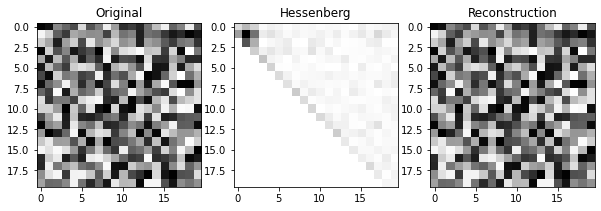

In [6]:
# Visualiation of Tranforming Matrix A to Hessenberg form via Householder Reflection

f, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(10,20))

n = 20
A = np.random.rand(n,n)
H, S = Hessenberg(A,eigvec=True, inplace=False)                   
recon = S.T @ H @ S

im = ax0.imshow(-abs(A),cmap='gray')
ax0.set_title('Original')
ax1.imshow(-abs(H),cmap='gray')
ax1.set_title('Hessenberg')
ax2.imshow(-abs(recon),cmap='gray')
ax2.set_title('Reconstruction')

print("Illustration of Transformation to Hessenberg Form ")


<br>

**Observations:**
- Hessenberg() function seems to be working for real matrices

<br><br>


In [7]:
### Testing Hessenberg() on Random Complex Matrices

print('\n\n')
print("====================================================================")
print('Testing Hessenberg() function on randomly generated COMPLEX matrices')
print("====================================================================")

#for n in [3,5,10,100]:
#    A = np.random.rand(n,n)+np.random.rand(n,n)*1j 

for A in RANDOM_COMPLEX_MATRICES:   
    print('\n\nComplex >>> Input shape = {}'.format(A.shape))
    Hessenberg_A, S = Hessenberg(A,eigvec=True,inplace=False)
    scipy_hess_A = hessenberg(A)
    print('\nscipy.linalg.hessenberg and my Hessenberg close?',np.allclose(scipy_hess_A,Hessenberg_A))
    if not np.allclose(scipy_hess_A,Hessenberg_A):
        #print('scipy.linalg.hessenberg and my Hessenberg close in abs() except signs?',np.allclose(np.abs(scipy_hess_A),np.abs(Hessenberg_A)))
        print('scipy.linalg.hessenberg and my Hessenberg close in absolute values of re() and im()?',
              np.allclose(np.abs(np.real(scipy_hess_A)),np.abs(np.real(Hessenberg_A))),
              np.allclose(np.abs(np.imag(scipy_hess_A)),np.abs(np.imag(Hessenberg_A))))
        #print(np.real(scipy_hess_A),'\n',np.real(Hessenberg_A),'\n\n',np.imag(scipy_hess_A),'\n',np.imag(Hessenberg_A))
    print('\nReconstructed matrix S.T@H@S close to input?',np.allclose(A, S.conjugate().T@Hessenberg_A@S))
    
#    n = A.shape[0]
#    if n <=5:
#        print('\ninput matrix=\n', A)
#        print('\nreconstructed matrix=\n',S.conjugate().T@Hessenberg_A@S)
#        print('\nscipy.linalg.hessenberg=\n',scipy_hess_A)
#        print('\nmy Hessenberg=\n',Hessenberg_A)

                




Testing Hessenberg() function on randomly generated COMPLEX matrices


Complex >>> Input shape = (3, 3)

scipy.linalg.hessenberg and my Hessenberg close? False
scipy.linalg.hessenberg and my Hessenberg close in absolute values of re() and im()? True True

Reconstructed matrix S.T@H@S close to input? True


Complex >>> Input shape = (5, 5)

scipy.linalg.hessenberg and my Hessenberg close? False
scipy.linalg.hessenberg and my Hessenberg close in absolute values of re() and im()? True True

Reconstructed matrix S.T@H@S close to input? True


Complex >>> Input shape = (10, 10)

scipy.linalg.hessenberg and my Hessenberg close? False
scipy.linalg.hessenberg and my Hessenberg close in absolute values of re() and im()? True True

Reconstructed matrix S.T@H@S close to input? True


<br>

**Observations:**
- Hessenberg() function works for complex matrices as well 
- Modified for the optional output of the similarity transformation matrix S
<br>
<br>


## Givens Rotation
<br>

<img src="figures/GivensRotation.png"/>

*Modified from Image Source: https://www.slideserve.com/pekelo/scientific-computing-chapter-3-linear-least-squares, https://de.wikipedia.org/wiki/Givens-Rotation*



If $x_j$ and $ x_k$ are real numbers:

- $\begin{bmatrix} c & s \\ -s & c \end{bmatrix} \begin{bmatrix} x_j \\ x_k \end{bmatrix} = \begin{bmatrix} r \\ 0 \end{bmatrix}$, where $r = \sqrt{x_j^2 + x_k^2}$, $c= x_j / r$ and $s= x_k / r$


If $x_j$ and $x_k$ are complex numbers:
- $\begin{bmatrix} c & s \\ -{\overline{s}} & c \end{bmatrix} \begin{bmatrix} x_j \\ x_k \end{bmatrix} = \begin{bmatrix} r \\ 0 \end{bmatrix} $, where 


- $c= x_j^* / \sqrt{\vert x_j \vert ^2 + \vert x_k \vert ^2} = cos \theta_a e^{-i \theta_j}$ 


- $s= x_k^* / \sqrt{\vert x_j \vert ^2 + \vert x_k \vert ^2} = sin \theta_a e^{-i \theta_k}$ 


- $\theta_a = arctan(\vert x_k \vert / \vert x_j \vert) = arctan( Re(x_k) / cos \theta_k \times cos \theta_j / Re(x_j))$

*Source: https://amir.sdsu.edu/Wen17A.pdf, page 2, equations (7) and (8)*

<br>


In [9]:
def Givens(x_j,x_k):
    
    """ Find the Givens rotation matrix such that G @ [x_j,x_k] = [*, 0] 
    Input   ---------------------------------------------- 
            x_j: jth row/column element from a np.array with real or complex entries
            x_k: kth row/column element from a np.array with real or complex entries
            
    Return  ---------------------------------------------
            G: 2x2 rotation matrix in np.array with real or complex entries 
    """


    if x_k == 0. or x_k.real == 0: #x_k== 0+0*1j : # including the case x_j=0 and x_k=0
        c = 1.
        s = 0.
        
    elif x_j == 0. or x_j.real == 0: #x_j == 0+0*1j : # i.e. x_k!=0
        c = 0.
        s = 1. 
    
    else: # f, g both non-zero
        theta_j = cmath.phase(x_j)
        theta_k = cmath.phase(x_k)
        theta_a = np.arctan(x_k.real/np.cos(theta_k)*np.cos(theta_j)/x_j.real) #div by zero excluded from condition above
        c = np.cos(theta_a)*np.exp(-1j*theta_j)
        s = np.sin(theta_a)*np.exp(-1j*theta_k)

    if x_j.dtype == 'complex' or x_k.dtype == 'complex': 
        G = np.array([[c,s],[-s.conjugate(),c.conjugate()]]).astype('complex')
        
    else:
        G = np.array([[c,s],[-s,c]]).astype('float')
        
    return G 



# Previous unsuccessful attempts
# (Source: https://www.netlib.org/lapack/lawnspdf/lawn148.pdf, p.5) -> implementation does not work for complex matrices.

#def __Givens__(f,g):
#    if g == 0:
#        c = 1
#        s = 0
#        r = f        
#    elif f == 0: # g!=0
#        c = 0
#        s = np.sign(g.conjugate())
#        r = np.abs(g)   
#    else: # f, g both non-zero       
#        d = np.sqrt(np.abs(f)**2 +np.abs(g)**2 )
#        c = np.abs(f) / d 
#        s = np.sign(f) * (g.conjugate()) / d
#        r = np.sign(f) * d       
#    G = np.array([[c,s],[-s.conjugate(),c]])
#    return G
 

#def Givens_real(x_j, x_k):
#    """Avoiding squaring of small numbers
#    TODO: Need to adapt for complex numbers
#    """
#    # if the subdiagonal is already zero or close enough to zero, just return identity matrix
#    if abs(x_j) > abs(x_k) and x_j!=0:
#        tan = x_k / x_j
#        c = 1/np.sqrt(1+np.square(tan))
#        s = tan*c
#    else:
#        cotan = x_j / x_k
#        s = 1/np.sqrt(1+np.square(cotan))
#        c = cotan*s
#    G = np.array([[c,s],[-s,c]])    
#    return G


#def QR_Givens_naive(H):
#    '''Input: matrix H in Hessenberg form
#       Matrix multiplication directly 
#    '''
#    n = H.shape[0]
#    G = np.eye(n)
#    for i in range(n-1): # apply (n-1) Givens rotations to zero-out the sub-diagonal elements in Hessenberg matrix
#        G_ = np.eye(n)
#        G_[i:i+2, i:i+2] = Givens(H[i,i],H[i+1,i])
#        G = G_ @ G 
#    R = G @ H
#    Q = G.conjugate().T
#    return Q, R

# [Gn ... G2 G1].T [Gn ... G2 G1] H = H; 


#def QR_Givens_rows(H,eigvec=False):
#    '''Row-wise application of Givens rotation (2 rows at a time) rather than whole matrix multiplication
#    Input: H = numpy array, Hessenberg matrix
#    eigvec = Bool, indicating whether eigenvectors is required; if True, store and output all Givens matrics
#    Return: Updated H_new overwritten on H_old // no explicit calculation of Q and R matrices 
#    '''   
#    n = H.shape[0]
#    G_store = []
#    G_iter = np.eye(n,dtype=H.dtype)
#    
#    for i in range(n-1):
#        G = Givens(H[i,i],H[i+1,i])
#        new_rows = G @ H[i:i+2, :]
#        H[i:i+2, :] = new_rows
#        G_store.append(G)
#        
#        # if eigenvectors are required
#        if eigvec:
#            G_ = np.eye(n,dtype=H.dtype)
#            G_[i:i+2,i:i+2] = G
#            G_iter = G_ @ G_iter
#      
#    for i in range(n-1):
#        G = G_store.pop(0) #same order as above G1, G2, ...
#        
#        if G.dtype != 'complex':
#            new_cols = H[:, i:i+2] @ G.T
#        else:
#            new_cols = H[:, i:i+2] @ G.conjugate().T         
#        
#        H[:, i:i+2] = new_cols
#            
#    return H, G_iter  



def select_idx(i,n,tridiagonal):
    
    """ Find the start and end indices for element-wise application of Givens Rotation
    Input   ---------------------------------------------- 
            i: ith row/column of current application 
            n: total number of rows / columns
            tridiagonal: bool, indicating whether the matrix is tridiagonal
    Return  ---------------------------------------------
            row_start: start index for row operations  
            col_end: end index for column operations
    """
    
    if tridiagonal: # only operates on 3 elements per row / column 
        row_start = max(0,i-1) # for post multiplication of G.T
        col_end = i+3 
    
    else:
        row_start = 0
        col_end = n

    return row_start, col_end



def QR_Givens(H, eigvec=False, inplace=True, tridiagonal=False):
    
    """ Perform QR decomposition on a Hessenberg matrix by applying Givens Rotation 
        (element-wise rather than whole matrix multiplication)  
        No explicit computation of Q and R matrices; output updated Hessenberg matrix directly
        
    Input   ---------------------------------------------- 
            H: 2D np.array with real or complex entries, in the form of an upper Hessenberg matrix of shape n x n (square matrix)
            eigvec : bool, indicating whether eigenvectors are required; default is False
            inplace: bool, indicating whether to update H in place; default is True
            tridiagonal: bool, indicating whether H is tridiagonal; default is False
    
    Return  ---------------------------------------------
            H_new: 2D np.array with real or complex entries, in the form of an *updated* Hessenberg matrix, effectively R@Q 
            
            G_iter: 2D np.array, the accumulated Givens rotation matrix, effectively Q.T; 
                    if eigvec is False, not explicitly calculated and output identity matrix
            
            R = G @ H_old : applying Givens rotation G = Gn @ ... @ G2 @ G1 column by column to reduce Hessenberg to upper triangular
            H_old = G.T @ R => Q = G.T 
            H_new = R @ Q = G @ H_old @ G.T : update Hessenberg matrix (no explicite calculation )
            G_iter = G = Gn @ ... @ G2 @ G1 : this is effectively the Givens rotation per round of QR iteration
    """
    
    n = H.shape[0]
    G_store = []
    G_iter = np.eye(n,dtype=H.dtype)
    
    if inplace:
        H_old = H
    else:
        H_old = H.copy()
    
    for i in range(n-1):
        
        _, col_end = select_idx(i,n,tridiagonal)
        
        G = Givens(H_old[i,i],H_old[i+1,i])
        
        # Premultiplication by a rotation in the (i, i+1)-plane only involves rows i and i+1 and leaves other rows unaffected
        # Furthermore, only consider non-zero entries in these two rows, to avoid unnecessary multiplication by zero 
        H_old[i:i+2,i:col_end] = G @ H_old[i:i+2, i:col_end]
        
        G_store.append(G)
        
        # if eigenvectors are required
        if eigvec:
            G_ = np.eye(n,dtype=H.dtype)
            G_[i:i+2,i:i+2] = G
            G_iter = G_ @ G_iter
    
    # H_old is now effectively R; next is to obtain H_new = R @ Q where Q = G1.T G2.T ...Gn-1.T
    
    H_new = H_old

    for i in range(n-1):
        row_start, _ = select_idx(i,n,tridiagonal)

        G = G_store.pop(0) #same order as above G1, G2, ...
        
        if G.dtype != 'complex':
            G_T = G.T
        else:
            G_T = G.conjugate().T
        
        # Similar to above, postmultiplication by a rotation in the (i, i+1)-plane affects only columns i and i+1.
        H_new[row_start:i+2, i:i+2] = H_new[row_start:i+2, i:i+2] @ G_T 
        
    # H_new is the updated version, effectively R @ Q

    return H_new, G_iter  



In [10]:
### Testing QR_Givens() on Random Complex Matrices

print('\n\n')
print("====================================================================")
print('Testing QR_Givens() function on randomly generated COMPLEX matrices')
print("====================================================================")

for A in RANDOM_COMPLEX_MATRICES:   
    print('\n\nComplex >>> Input shape = {}'.format(A.shape))
    H, S = Hessenberg(A,eigvec=True)
    #print('A =\n',A)
    #print('H =\n',H)

    H_new, G = QR_Givens(H,eigvec=True, tridiagonal=False)
    Q = G.T
    print('\nQR_Givens: H_new=\n',H_new)
    print('Q.conjugate().T @ Q = np.eye(n)? ',np.allclose(Q.conjugate().T@Q,np.eye(A.shape[0], dtype='complex')))

    
    
    
### Testing QR_Givens() on Random REAL Matrices

print('\n\n')
print("====================================================================")
print('Testing QR_Givens() function on randomly generated REAL matrices')
print("====================================================================")

for A in RANDOM_REAL_MATRICES:   
    print('\n\nComplex >>> Input shape = {}'.format(A.shape))
    H, S = Hessenberg(A,eigvec=True)
    #print('A =\n',A)
    #print('H =\n',H)

    H_new, G = QR_Givens(H,eigvec=True, tridiagonal=False)
    Q = G.T
    print('\nQR_Givens: H_new=\n',H_new)
    print('Q.T @ Q = np.eye(n)? ',np.allclose(Q.T@Q,np.eye(A.shape[0])))



    
### Testing QR_Givens() on Random Complex Matrices

print('\n\n')
print("====================================================================")
print('Testing QR_Givens() function on SPECIAL real matrices')
print("====================================================================")

for A in SPECIAL_REAL_MATRICES:   
    print('\n\nSpecial >>> Input shape = {}'.format(A.shape))
    H, S = Hessenberg(A,eigvec=True)
    #print('A =\n',A)
    #print('H =\n',H)

    H_new, G = QR_Givens(H,eigvec=True, tridiagonal=True)
    Q = G.T
    print('\nQR_Givens: H_new=\n',H_new)
    print('Q.T @ Q = np.eye(n)? ',np.allclose(Q.T@Q,np.eye(A.shape[0])))

    




Testing QR_Givens() function on randomly generated COMPLEX matrices


Complex >>> Input shape = (3, 3)

QR_Givens: H_new=
 [[ 1.547+1.438j  0.288-0.896j  0.856-0.45j ]
 [-0.677-0.j     0.402-0.333j -0.096-0.059j]
 [ 0.   -0.j     0.033+0.081j  0.035-0.13j ]]
Q.conjugate().T @ Q = np.eye(n)?  True


Complex >>> Input shape = (5, 5)

QR_Givens: H_new=
 [[ 2.081+2.091j -0.111-0.981j -0.224+0.181j  0.197-0.359j  0.353+0.104j]
 [-0.733+0.j     0.077+0.777j -0.204-0.177j  0.066-0.478j  0.475-0.164j]
 [ 0.   +0.j     0.443+0.j    -0.144-0.247j  0.003-0.088j -0.344-0.207j]
 [ 0.   -0.j     0.   +0.j    -0.531+0.j    -0.36 +0.057j  0.07 -0.j   ]
 [ 0.   +0.j    -0.   -0.j    -0.   +0.j    -0.028-0.168j -0.084+0.72j ]]
Q.conjugate().T @ Q = np.eye(n)?  True


Complex >>> Input shape = (10, 10)

QR_Givens: H_new=
 [[ 3.65 +4.147j  0.258-2.361j  0.102-0.964j -0.403+0.485j -0.269+0.468j  0.414-0.241j -0.411+0.212j -0.569+0.084j -0.183+0.146j  0.93 -0.711j]
 [-3.069+0.j     0.917+1.403j -0.566+0.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


<br>

**Observation:**
- Function QR_Givens() seems to be working for both real and complex matrices as expected
- <span style="color:red">**Where does the complex warning come from??**</span>

<br>



## QR Iteration

##### Some Background Information
Source: https://scicomp.stackexchange.com/questions/30407/how-does-the-qr-algorithm-applied-to-a-real-matrix-returns-complex-eigenvalues
- QR algorithm converges to the real Schur decomposition: a unitary matrix Q and a matrix R in block upper triangular form such that $A = Q R Q^T$
- The key point is the *block upper triangular* form, which means here $R_{ii}$ are real blocks of 
  - EITHER **size 1x1** ($R_{ii}$ is a (real) eigenvalue of A)
  - OR **size 2x2** ($R_{ii}$ has a pair of complex conjugate eigenvalues). 

<br>


In [11]:
#def QR_Iteration_Eigenvalues_naive(A, max_iter, tol):
#    # step 1: tranform A to Hessenberg
#    H, _ = Hessenberg(A)
#    # step 2: QR iteration 
#    H_old = H    
#    for i in range(max_iter):
#        Q, R = QR_Givens_naive(H_old)
#        H_new = R @ Q
#        # TODO: test for convergence
#        if np.linalg.norm(H_new - H) < tol:
#            print('break at i=',i,np.linalg.norm(H_new - H),H_new)
#            break           
#        H_old = H_new
#    R = H_new
#    return np.diag(R) # this is wrong 


def diagonal_block(R):
    
    """     Read eigenvalues from the diagonal block matrix R, either in 1x1 block (i.e. real eigenvalue) 
            or in 2x2 block (i.e. complex conjugate pair)
    Input   ---------------------------------------------- 
            R: 2D np.array with real or complex entries, in the form of a block upper triangular matrix 
    Return  ---------------------------------------------
            eigenvalues: 1D np.array with real or complex entries
    """

    eigenvalues = []
    
    for i in range(len(R)):
        if i < len(eigenvalues): # if current diagonal values has already been used in previous step, skip
            continue
        
        if i ==len(R)-1 or np.abs(R[i+1,i]) < ATOL: # if subdiagonal element is sufficiently small, treat as zero OR if last row
            eigenvalues.append(R[i,i])
        
        else:
            # solving eigenvalues from characteristic polynomial lam^2 - (R[i,i]+R[i+1,i+1])*lam + (R[i,i]*R[i+1,i+1] - R[i,i+1]*R[i+1,i]) = 0
            b = - (R[i,i]+R[i+1,i+1])
            c = R[i,i]*R[i+1,i+1] - R[i,i+1]*R[i+1,i]
            
            lam_1 = -b/2
            sign = np.sign(lam_1)
            
            if b**2 - 4*c >= 0:
                lam_2 = np.sqrt(b**2-4*c)/2
                eigenvalues.append(lam_1 + sign*lam_2)
                eigenvalues.append(lam_1 - sign*lam_2)
            else:
                lam_2 = np.sqrt(-(b**2-4*c))/2
                eigenvalues.append(lam_1 + sign*lam_2*1j)
                eigenvalues.append(lam_1 - sign*lam_2*1j)

    return np.array(eigenvalues)



def QR_Iteration_Eigenvalues(A, max_iter, tol):
    
    """     Perform QR iteration to obtain eigenvalues
    Input   ---------------------------------------------- 
            A: 2D np.array with real or complex entries
            max_iter: int, maximum number of iterations to be performed
            tol: float, relative tolerance between eigenvalues by successive iterations
    Return  ---------------------------------------------
            eigvals_new: 1D np.array with real or complex entries
            i: total number of iterations
    """

    
    # step 1: tranform A to Hessenberg
    H, _ = Hessenberg(A) # default: eigvec=False, inplace=True
    
    # step 2: QR iteration 
    H_old = H #.copy()
    eigvals_old = diagonal_block(H)
    
    for i in range(max_iter):
        H_new,_ = QR_Givens(H_old) # updating H_old in-place # default QR_Givens(H,eigvec=False, inplace=True, tridiagonal=False)

        eigvals_new = diagonal_block(H_new)
        #print('>>>\n', H_new, '\n\n',np.diag(H_new), '\n')
        
        # Test for convergence: relative tol = 1- w / w' for each eigenvalue
        if np.allclose(eigvals_new, eigvals_old, rtol=tol):
            print('Iteration terminates at i={} with tol={} reached'.format(i,tol))
            break
            
        if i == max_iter-1:
            err = np.max(abs((eigvals_new - eigvals_old)) / abs(eigvals_old))
            idx = np.argwhere(np.isclose(eigvals_new, eigvals_old, rtol=tol)==False).tolist()
            print('max_iter={} reached, max error={} vs tol={}; index of non-convergence={}'.format(max_iter, err, tol, idx))

        eigvals_old = eigvals_new.copy() # need to save a copy for comparison in the next iteration
        # H_old = H_new # this is not needed as H_old is updated inplace

    return eigvals_new, i 




In [12]:
# Testing 

def sort_(eigenvalues):
    
    """     Sort eigenvalues in descending order by magitude; 
            following Numpy's extended sort order: Real: [R, nan]; Complex: [R + Rj, R + nanj, nan + Rj, nan + nanj]
    Input   ---------------------------------------------- 
            eigenvalues: 1D np.array with real or complex entries
    Return  ---------------------------------------------
            eigenvaluese_sorted: 1D np.array with real or complex entries, sorted in descending order
    """
    eigenvalues_sorted = np.flip(np.sort(eigenvalues))
    
    return eigenvalues_sorted

#    if eigenvalues.dtype != 'complex':
#        eigenvalues_sorted = np.sort(eigenvalues) #np.flip(sorted(eigenvalues,key=abs))
#    else:
#        eigenvalues_sorted = np.sort_complex(eigenvalues)
#    return eigenvalues_sorted
    


def test_eigenvalues_function(A,function):
    
    """     Perform eigenvalue testing on selected function; eigenvalues are compared with results from np.linalg.eig()
    Input   ---------------------------------------------- 
            A: input matrix, 2D np.array with real or complex entries
            function: name of the function being tested
    Return  ---------------------------------------------
            None; test results will be printed
    """

    print("------ Testing for function: {}() ------".format(function.__name__))
    w,v = np.linalg.eig(A)
    w_sorted = sort_(w)
    eigenvalues,i = function(A,max_iter=MAX_ITER, tol=RTOL)
    eigenvalues_sorted = sort_(eigenvalues)
    print()
    print('my eigenvalues: {}'.format(eigenvalues_sorted))
    print('np.linalg.eig:  {}'.format(w_sorted)) #sort in descending order of magnitutes
    
    if np.allclose(w_sorted,eigenvalues_sorted):
        print('\nnp.linalg.eig and my eigenvalues close? True \n')
    else:
        print('\nnp.linalg.eig and my eigenvalues close? False \n')
        print('\nmy eigenvalues - np.linalg.eig =\n', eigenvalues_sorted - w_sorted,'\n')

    print('\n')    
    

def test_eigenvalues(eigenvalues,w, verbose=True):
    
    """     Comparing two sets of eigenvalues
    Input   ---------------------------------------------- 
            eigenvalues: 1D np.array with real or complex entries, eigenvalues from my function
            w: eigenvalues from np.linalg.eig(), basis for comparison
            verbose: bool, indicating whether to print the difference between the two sets of eigenvalues
    Return  ---------------------------------------------
            None; test results will be printed
    """

    eigenvalues_sorted = sort_(eigenvalues)
    w_sorted = sort_(w)
    
    if verbose:
        print()
        print('my eigenvalues: {}'.format(eigenvalues_sorted))
        print('np.linalg.eig:  {}'.format(w_sorted)) #sort in descending order of magnitutes
    
    if np.allclose(w_sorted,eigenvalues_sorted):
        print('\nnp.linalg.eig and my eigenvalues close? True \n')
    else:
        print('\nnp.linalg.eig and my eigenvalues close? False \n')
        if verbose:
            print('my eigenvalues - np.linalg.eig =\n', eigenvalues_sorted - w_sorted,'\n')
            print('max abs diff = ',np.abs(eigenvalues_sorted - w_sorted).max(),'\n')
        print('\n')
        

In [43]:
### Testing QR_Iteration_Eigenvalues() on Random Complex Matrices

print('\n\n')
print("====================================================================================")
print('Testing QR_Iteration_Eigenvalues() function on randomly generated COMPLEX matrices')
print("====================================================================================")

for A in RANDOM_COMPLEX_MATRICES:   
    print('\nComplex >>> Input shape = {}\n'.format(A.shape))
    test_eigenvalues_function(A,QR_Iteration_Eigenvalues)



### Testing QR_Iteration_Eigenvalues() on Random Real Matrices

print('\n\n')
print("====================================================================================")
print('Testing QR_Iteration_Eigenvalues() function on randomly generated REAL matrices')
print("====================================================================================")

for A in RANDOM_REAL_MATRICES:   
    print('\nReal >>> Input shape = {}\n'.format(A.shape))
    test_eigenvalues_function(A,QR_Iteration_Eigenvalues)



### Testing QR_Iteration_Eigenvalues() on Special Matrices

print('\n\n')
print("====================================================================================")
print('Testing QR_Iteration_Eigenvalues() function on SPECIAL real matrices')
print("====================================================================================")

for A in SPECIAL_REAL_MATRICES:   
    print('\nSpecial >>> Input shape = {}\n'.format(A.shape))
    test_eigenvalues_function(A,QR_Iteration_Eigenvalues)







Testing QR_Iteration_Eigenvalues() function on randomly generated COMPLEX matrices

Complex >>> Input shape = (3, 3)

------ Testing for function: QR_Iteration_Eigenvalues() ------
Iteration terminates at i=11 with tol=1e-06 reached

my eigenvalues: [ 1.71 +1.655j  0.288-0.519j -0.015-0.161j]
np.linalg.eig:  [ 1.71 +1.655j  0.288-0.519j -0.015-0.161j]

np.linalg.eig and my eigenvalues close? True 




Complex >>> Input shape = (5, 5)

------ Testing for function: QR_Iteration_Eigenvalues() ------
Iteration terminates at i=935 with tol=1e-06 reached

my eigenvalues: [ 2.251+2.287j  0.132+0.508j -0.182+0.806j -0.189-0.474j -0.442+0.271j]
np.linalg.eig:  [ 2.251+2.287j  0.132+0.508j -0.182+0.806j -0.189-0.474j -0.442+0.271j]

np.linalg.eig and my eigenvalues close? True 




Complex >>> Input shape = (10, 10)

------ Testing for function: QR_Iteration_Eigenvalues() ------
Iteration terminates at i=74 with tol=1e-06 reached

my eigenvalues: [ 4.624+5.231j  1.242-0.661j  0.321-0.067j  0.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


Iteration terminates at i=558 with tol=1e-06 reached

my eigenvalues: [ 4.82 +0.j     0.579+0.149j  0.579-0.149j  0.377+0.j     0.146+0.j    -0.24 +0.j    -0.352+0.944j -0.352-0.944j -0.571+0.117j -0.571-0.117j]
np.linalg.eig:  [ 4.82 +0.j     0.579+0.149j  0.579-0.149j  0.377+0.j     0.146+0.j    -0.24 +0.j    -0.352+0.944j -0.352-0.944j -0.571+0.117j -0.571-0.117j]

np.linalg.eig and my eigenvalues close? True 






Testing QR_Iteration_Eigenvalues() function on SPECIAL real matrices

Special >>> Input shape = (10, 10)

------ Testing for function: QR_Iteration_Eigenvalues() ------
Iteration terminates at i=194 with tol=1e-06 reached

my eigenvalues: [  9.684   8.685   7.302   1.666  -1.201  -3.008  -5.856  -8.817 -11.764 -14.69 ]
np.linalg.eig:  [  9.684   8.685   7.302   1.666  -1.201  -3.008  -5.856  -8.817 -11.764 -14.69 ]

np.linalg.eig and my eigenvalues close? True 




Special >>> Input shape = (10, 10)

------ Testing for function: QR_Iteration_Eigenvalues() ------
Iteratio

**Observations:**

- Function QR_Iteration_Eigenvalues() seems to be working as expected with both real and complex matrices, with real eigenvalues or complex conjugate pairs 
- Underperformance in special matrices: diagonal dominant and unbalanced

   - *real symmetric* A = np.random.randint(-3,3,(10,10)) A = (A.T + A).astype('float')

   - *diagonal dominant*  B = A - np.triu(A,1)*0.99 - np.tril(A,-1)*0.99 

   - *unbalanced* C = np.tril(np.ones((10,10),dtype='float'),0)

<br>


In [14]:
### Testing QR_Iteration_Eigenvalues() on COMPLEX Matrices with only pure imaginary parts

print('\n\n')
print("====================================================================================")
print('Testing QR_Iteration_Eigenvalues() function on SPECIAL complex matrices (Im Only)')
print("====================================================================================")

A = np.random.rand(5,5) * 1j
print('\nSpecial >>> Input shape = {}\n'.format(A.shape))
test_eigenvalues_function(A,QR_Iteration_Eigenvalues)





Testing QR_Iteration_Eigenvalues() function on SPECIAL complex matrices (Im Only)

Special >>> Input shape = (5, 5)

------ Testing for function: QR_Iteration_Eigenvalues() ------
Iteration terminates at i=23 with tol=1e-06 reached

my eigenvalues: [ 0.561+0.013j  0.   -0.296j  0.   +0.978j  0.   -2.01j  -0.561+0.013j]
np.linalg.eig:  [ 0.752+0.172j  0.   +2.607j  0.   -0.248j  0.   -0.023j -0.752+0.172j]

np.linalg.eig and my eigenvalues close? False 


my eigenvalues - np.linalg.eig =
 [-0.192-0.159j  0.   -2.903j  0.   +1.225j  0.   -1.986j  0.192-0.159j] 





**Observations:**
- Does not seem to work for matrices with pure imaginary parts ... **<span style="color:red">#TODO</span>**

<br>


### Wilkinson Shift

<img src="figures/WilkinsonShift.png" />

*Source: NLA Lecture Notes*

<br>


In [15]:

def Wilkinson_shift(H):
    
    """     Using the bottom right 2x2 block of Hessenberg matrix to determine if eigenvalues are real or complex (b^2-4ac) 
            Calculate the Wilkinson's shift according to Lecture Notes 1.4.22 Definition (Wilkinson shift)
    Input   ---------------------------------------------- 
            H: 2D np.array with real or complex entries, in the form of an upper Hessenberg matrix
    Return  ---------------------------------------------
            datatype: 'complex' or 'float'
            lam1 or lam2: shift to be performed
    """
    
    n = H.shape[0]
    
    # find the current index where the subdiagonal is non-zero 
    # (if the subdiagonal is zero, it means the shift has worked and converged to an eigenvalue)
    while abs(H[n-1,n-2]) < ATOL: #global variable ATOL = 1e-18, proxy for zero
        n -= 1
    
    # M is the bottom right 2x2 block with nonzero subdiagonal (equivalent to the idea of deflation) 
    M = H[n-2:n,n-2:n]
    
    # characteristic polynomial x^2 + bx + c = 0
    b = -(M[0,0] + M[1,1])
    c = (M[0,0]*M[1,1] - M[1,0]*M[0,1])
    
    # if real eigenvalues - return the one closer to A[n,n]' 
    if b**2 >= 4*c:    
        lam1 = (-b + np.sqrt(b**2-4*c))/2
        lam2 = (-b - np.sqrt(b**2-4*c))/2
        datatype = 'float'
        
    # if complex eigenvalues - return Re(x) and Im(x)    
    else:
        re_ = -b/2
        im_ = np.sqrt(4*c-b**2)/2
        lam1 = re_+1j*im_
        lam2 = re_+1j*im_
        datatype = 'complex'
        
    if abs(lam1-M[1,1]) < abs(lam2-M[1,1]):
        return (datatype, lam1)
    
    else:
        return (datatype, lam2)
    


def QR_Iteration_WilkinsonShift(A, max_iter, tol):
    
    """     Perform QR iteration with Wilkinson's shift to obtain eigenvalues
    Input   ---------------------------------------------- 
            A: 2D np.array with real or complex entries
            max_iter: int, maximum number of iterations to be performed
            tol: float, relative tolerance between eigenvalues by successive iterations
    Return  ---------------------------------------------
            eigvals_new: 1D np.array with real or complex entries
            i: total number of iterations
    """
    
    n = A.shape[0]
    
    # step 1: tranform A to Hessenberg
    H, _ = Hessenberg(A)
    
    # step 2: QR iteration 
    H_old = H.copy()    
    eigvals_old = diagonal_block(H)
            
    for i in range(max_iter):

        datatype, lam = Wilkinson_shift(H_old)
        # print(">>> Wilkinson_shift = {}".format(lam))

        # H_old = H_old - lam * np.eye(n)
        for j in range(n):
            H_old[j,j] -= lam
        
        #H_new, _ = QR_Givens(H_old) +  lam * np.eye(n) # updating H_old in-place  # default QR_Givens(H,eigvec=False, inplace=True, tridiagonal=False
        H_new, _ = QR_Givens(H_old)
        for j in range(n):
            H_new[j,j] += lam
            
        eigvals_new = diagonal_block(H_new)
        H_old = H_new

        # Test for convergence: relative tol = 1- w / w' for each eigenvalue
        if np.allclose(eigvals_new, eigvals_old, rtol=tol):
            print('Iteration terminates at i={} with tol={} reached'.format(i,tol))
            break

        if i == max_iter-1:
            err = np.max(abs((eigvals_new - eigvals_old)) / abs(eigvals_old))
            idx = np.argwhere(np.isclose(eigvals_new, eigvals_old, rtol=tol)==False).tolist()
            print('max_iter={} reached, max error={} vs tol={}; index of non-convergence={}'.format(max_iter, err, tol, idx))

        eigvals_old = eigvals_new

    return eigvals_new, i 




In [16]:
### Testing QR_Iteration_WilkinsonShift() on Random Complex Matrices

print('\n\n')
print("====================================================================================")
print('Testing QR_Iteration_WilkinsonShift() function on randomly generated COMPLEX matrices')
print("====================================================================================")

for A in RANDOM_COMPLEX_MATRICES:   
    print('\nComplex >>> Input shape = {}\n'.format(A.shape))
    test_eigenvalues_function(A,QR_Iteration_Eigenvalues)
    test_eigenvalues_function(A,QR_Iteration_WilkinsonShift)

    
### Testing QR_Iteration_WilkinsonShift() on Random Real Matrices

print('\n\n')
print("====================================================================================")
print('Testing QR_Iteration_WilkinsonShift() function on randomly generated REAL matrices')
print("====================================================================================")

for A in RANDOM_REAL_MATRICES:   
    print('\nReal >>> Input shape = {}\n'.format(A.shape))
    test_eigenvalues_function(A,QR_Iteration_Eigenvalues)
    test_eigenvalues_function(A,QR_Iteration_WilkinsonShift)

    
### Testing QR_Iteration_WilkinsonShift() on Special Matrices

print('\n\n')
print("====================================================================================")
print('Testing QR_Iteration_WilkinsonShift() function on SPECIAL real matrices')
print("====================================================================================")

for A in SPECIAL_REAL_MATRICES:   
    print('\nSpecial >>> Input shape = {}\n'.format(A.shape))
    test_eigenvalues_function(A,QR_Iteration_Eigenvalues)
    test_eigenvalues_function(A,QR_Iteration_WilkinsonShift)







Testing QR_Iteration_WilkinsonShift() function on randomly generated COMPLEX matrices

Complex >>> Input shape = (3, 3)

------ Testing for function: QR_Iteration_Eigenvalues() ------
Iteration terminates at i=11 with tol=1e-06 reached

my eigenvalues: [ 1.71 +1.655j  0.288-0.519j -0.015-0.161j]
np.linalg.eig:  [ 1.71 +1.655j  0.288-0.519j -0.015-0.161j]

np.linalg.eig and my eigenvalues close? True 



------ Testing for function: QR_Iteration_WilkinsonShift() ------
Iteration terminates at i=5 with tol=1e-06 reached

my eigenvalues: [ 1.71 +1.655j  0.288-0.519j -0.015-0.161j]
np.linalg.eig:  [ 1.71 +1.655j  0.288-0.519j -0.015-0.161j]

np.linalg.eig and my eigenvalues close? True 




Complex >>> Input shape = (5, 5)

------ Testing for function: QR_Iteration_Eigenvalues() ------
Iteration terminates at i=935 with tol=1e-06 reached

my eigenvalues: [ 2.251+2.287j  0.132+0.508j -0.182+0.806j -0.189-0.474j -0.442+0.271j]
np.linalg.eig:  [ 2.251+2.287j  0.132+0.508j -0.182+0.806j -0.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: ComplexWarning: Casting complex values to real discards the imaginary part


Iteration terminates at i=558 with tol=1e-06 reached

my eigenvalues: [ 4.82 +0.j     0.579+0.149j  0.579-0.149j  0.377+0.j     0.146+0.j    -0.24 +0.j    -0.352+0.944j -0.352-0.944j -0.571+0.117j -0.571-0.117j]
np.linalg.eig:  [ 4.82 +0.j     0.579+0.149j  0.579-0.149j  0.377+0.j     0.146+0.j    -0.24 +0.j    -0.352+0.944j -0.352-0.944j -0.571+0.117j -0.571-0.117j]

np.linalg.eig and my eigenvalues close? True 



------ Testing for function: QR_Iteration_WilkinsonShift() ------
Iteration terminates at i=465 with tol=1e-06 reached

my eigenvalues: [ 4.82 +0.j     0.579+0.149j  0.579-0.149j  0.377+0.j     0.146+0.j    -0.24 +0.j    -0.352+0.944j -0.352-0.944j -0.571+0.117j -0.571-0.117j]
np.linalg.eig:  [ 4.82 +0.j     0.579+0.149j  0.579-0.149j  0.377+0.j     0.146+0.j    -0.24 +0.j    -0.352+0.944j -0.352-0.944j -0.571+0.117j -0.571-0.117j]

np.linalg.eig and my eigenvalues close? True 






Testing QR_Iteration_WilkinsonShift() function on SPECIAL real matrices

Special >>> Input 

**Observations:**

- Function QR_Iteration_WilkinsonShift() seems to be working as expected with both real and complex matrices, with real eigenvalues or complex conjugate pairs 
- Same issue with special matrices -> diagonal dominant with ones in lower triangular 

<br>


### Visualization of Convergence Comparison with Wilkinson's Shift

<br>




Random Complex >>> Input shape =  (5, 5)

QR Iteration without shift:
Iteration terminates at i=559 with tol=1e-06 reached

QR Iteration with WILKINSON shift:
Iteration terminates at i=18 with tol=1e-06 reached


Random Complex >>> Input shape =  (25, 25)

QR Iteration without shift:
Iteration terminates at i=3283 with tol=1e-06 reached

QR Iteration with WILKINSON shift:
Iteration terminates at i=312 with tol=1e-06 reached


Random Complex >>> Input shape =  (50, 50)

QR Iteration without shift:
Iteration terminates at i=8193 with tol=1e-06 reached

QR Iteration with WILKINSON shift:
Iteration terminates at i=1132 with tol=1e-06 reached


Random Complex >>> Input shape =  (75, 75)

QR Iteration without shift:
max_iter=10000 reached, max error=0.00947315121975121 vs tol=1e-06; index of non-convergence=[[16], [17], [36], [38]]

QR Iteration with WILKINSON shift:
Iteration terminates at i=3130 with tol=1e-06 reached


Random Complex >>> Input shape =  (100, 100)

QR Iteration without s

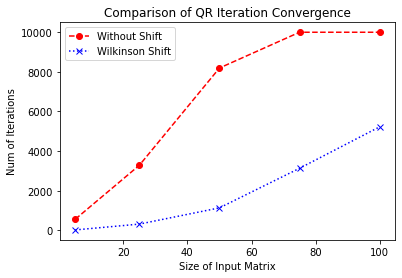

In [17]:
# TAKES QUITE A WHILE - RERUN ONLY IF NEEDED!

size = [5,25,50,75,100]
no_shift = []
Wilkinson = []

for n in size:
    A = np.random.rand(n,n)+1j*np.random.rand(n,n)
    print('\n\nRandom Complex >>> Input shape = ',A.shape)
    eig,_ = np.linalg.eig(A)
    print('\nQR Iteration without shift:')
    eig_, i_ = QR_Iteration_Eigenvalues(A, max_iter = 10000, tol=RTOL)
    print('\nQR Iteration with WILKINSON shift:')
    eig_w, i_w = QR_Iteration_WilkinsonShift(A,max_iter = 10000, tol=RTOL)
    no_shift.append(i_)
    Wilkinson.append(i_w)
    #print('np.linalg.eig:              ', sort_(eig))
    #print('QR_Iteration:               ', sort_(eig_))
    #print('QR_Iteration_WilkinsonShift:', sort_(eig_w))
    
plt.plot(size, no_shift,marker='o',color='red',linestyle='dashed',label='Without Shift')
plt.plot(size, Wilkinson,marker='x',color='blue',linestyle='dotted',label='Wilkinson Shift')
plt.title('Comparison of QR Iteration Convergence')
plt.xlabel('Size of Input Matrix')
plt.ylabel('Num of Iterations')
plt.legend()
plt.show()


<br>

### Eigenvectors

Two similar matrices, $A$ and $B$, with similarity transformation $B = S^{−1} A  S$, have the same set of eigenvalues and their eigenvectors are related $v_B = S^{−1} v_A$.

Reference sources:
- Implementing the QR algorithm for efficiently computing matrix eigenvalues and eigenvectors - Section 4.5 (p.51) https://addi.ehu.es/bitstream/handle/10810/26427/TFG_Erana_Robles_Gorka.pdf?sequence=1

- Find eigenvectors of an upper triangular matrix 

(1) https://math.stackexchange.com/questions/2632460/general-form-of-left-and-right-eigenvectors-of-upper-triangular-matrices

(2) https://math.stackexchange.com/questions/3947108/how-to-get-eigenvectors-using-qr-algorithm

In [18]:
# Find Eigenvector of an upper triangular matrix given eigenvectors

def eigenvectors_upperTriangularMatrix(U,eigenvalues):
        
    """     Compute the eigenvectors of an upper triangular matrix, based on given eigenvalues
            Source: https://addi.ehu.es/bitstream/handle/10810/26427/TFG_Erana_Robles_Gorka.pdf?sequence=1
    Input   ---------------------------------------------- 
            U: 2D np.array in the form of an upper triangular matrix
            eigenvalues: 1D np.array, real eigenvalues associated with matrix U
    Return  ---------------------------------------------
            V: 2D np.array with each column represents an eigenvector, in the same order as the associated eigenvalue
    """

    n = U.shape[0]

    V = np.eye(n, dtype=U.dtype) # in case of complex matrix, enforce dtype

    for i in range(1,n,1):
        for j in range(i-1,-1,-1):
            V[j,i]= - np.dot(U[j,:],V[:,i]) / (U[j,j]-eigenvalues[i])
        
        V[:,i] = V[:,i]/np.linalg.norm(V[:,i]) # vector normalization
            
    return V



In [19]:
# Test for eigenvectors

def test_eigenvectors(eigenvectors, v, verbose=True):
            
    """     Compare two sets of eigenvectors 
    Input   ---------------------------------------------- 
            eigenvectors: 2D np.array with real or complex entries, eigenvectors from my function
            v: 2D np.array, eigenvectors from np.linalg.eig(), basis for comparison
            verbose: bool, indicating whether to print the two sets of eigenvectors and ratios of eigenvectors/v
    Return  ---------------------------------------------
            None; test results will be printed
    """


    if np.allclose(eigenvectors,v,rtol=RTOL):
        print('np.linalg.eig and my function return the same eigenvectors? True \n')
    
    else:
        print('np.linalg.eig and my function return the same eigenvectors? False \n')
        d = np.divide(eigenvectors,v, where=(v!=0))
        if verbose:
            print('my eigenvectors =\n',eigenvectors,'\nnp.linalg.eig =\n',v, '\nmy eigenvectors / np.linalg.eig =\n', d,'\n')
        d_ = np.divide(d,d[0], where=(d[0]!=0))
        print('Eigenvectors all close except sign and/or scaling?', np.allclose(d_,np.ones(d.shape,d.dtype),rtol=RTOL))
        
        # special case of upper triangular matrix
        if np.allclose(np.tril(v,-1),np.zeros(d.shape,d.dtype)): 
            print('[Upper Triagular Matrix] Eigenvectors all close except signs?', 
                  np.allclose(np.abs(eigenvectors),np.abs(v),rtol=RTOL),'\n')
        print('\n\n')

    
def test_eigenvectors_function(A,eigenvalues,function):
            
    """     Perform eigenvector testing on selected function; eigenvectors are compared with results from np.linalg.eig()
    Input   ---------------------------------------------- 
            A: input matrix, 2D np.array with real or complex entries
            function: name of the function being tested
    Return  ---------------------------------------------
            None; test results will be printed
    """

    print("------ Testing for function: {}() ------".format(function.__name__))
    eigenvectors = function(A, eigenvalues)
    w,v = np.linalg.eig(A)
    
    test_eigenvectors(eigenvectors, v)

    

In [20]:
### Testing eigenvectors_upperTriangularMatrix() on Random Real Upper Triangular Matrices

print('\n\n')
print("====================================================================================")
print('Testing eigenvectors_upperTriangularMatrix() on Random REAL Upper Triangular Matrices')
print("====================================================================================")

for A in RANDOM_REAL_MATRICES:
    U = np.triu(A)
    print('\nREAL >>> Input shape = {}\n'.format(U.shape))
    print('U = \n',U)
    eigenvalues = np.diag(U)
    test_eigenvectors_function(U,eigenvalues,eigenvectors_upperTriangularMatrix)

    
### Testing eigenvectors_upperTriangularMatrix() on Random COMPLEX Upper Triangular Matrices

print('\n\n')
print("====================================================================================")
print('Testing eigenvectors_upperTriangularMatrix() on Random COMPLEX Upper Triangular Matrices')
print("====================================================================================")

for A in RANDOM_COMPLEX_MATRICES:
    U = np.triu(A)
    print('\nCOMPLEX >>> Input shape = {}\n'.format(U.shape))
    print('U = \n',U)
    eigenvalues = np.diag(U)
    test_eigenvectors_function(U,eigenvalues,eigenvectors_upperTriangularMatrix)





Testing eigenvectors_upperTriangularMatrix() on Random REAL Upper Triangular Matrices

REAL >>> Input shape = (3, 3)

U = 
 [[0.261 0.15  0.741]
 [0.    0.174 0.07 ]
 [0.    0.    0.583]]
------ Testing for function: eigenvectors_upperTriangularMatrix() ------
np.linalg.eig and my function return the same eigenvectors? True 


REAL >>> Input shape = (5, 5)

U = 
 [[0.118 0.985 0.164 0.45  0.808]
 [0.    0.35  0.155 0.424 0.595]
 [0.    0.    0.497 0.135 0.143]
 [0.    0.    0.    0.706 0.689]
 [0.    0.    0.    0.    0.418]]
------ Testing for function: eigenvectors_upperTriangularMatrix() ------
np.linalg.eig and my function return the same eigenvectors? True 


REAL >>> Input shape = (10, 10)

U = 
 [[0.842 0.604 0.581 0.121 0.591 0.322 0.824 0.236 0.569 0.429]
 [0.    0.375 0.832 0.701 0.155 0.575 0.078 0.99  0.485 0.793]
 [0.    0.    0.083 0.414 0.819 0.3   0.075 0.567 0.834 0.001]
 [0.    0.    0.    0.009 0.453 0.353 0.712 0.761 0.973 0.933]
 [0.    0.    0.    0.    0.361 0

**Observations:**
- Seems to be working except for the signs of eigenvectors

In [21]:
# General method for obtaining eigenvectors 

def inverse_power_method_with_shift(A, s, max_iter=MAX_ITER, rtol=RTOL):
    
    """     Apply the inverse power method with shift to compute the eigenvectors associated with an eigenvalue which is close to the shift
    Input   ---------------------------------------------- 
            A: input matrix, 2D np.array wiht real or complex entries
            s: shift to be performed, which is closed to an eigenvalue
            max_iter: int, maximum number of iterations to be performed
            rtol: float, relative tolerance between eigenvalues by successive iterations
    Return  ---------------------------------------------
            x_new: 1D np.array, the eigenvector associated with the eigenvalue which is closed to the given shift
    """
    
    n = A.shape[0]
    A_ = A.astype(s.dtype) - s*np.eye(n,dtype=s.dtype)
    x_old = np.ones(n, dtype=s.dtype) #initialization as [1,1,1,...]
    
    for i in range(max_iter):
        y = np.linalg.solve(A_,x_old) # assuming this can be used? Potentially Singular Matrix Error...
        x_new = y/np.linalg.norm(y)
        
        if np.allclose(x_new,x_old,rtol=rtol):
            print('... num of iterations with inverse power method =',i)
            break
        x_old = x_new
        
    return x_new



def eigenvectors_inversePowerMethod(U,eigenvalues):

    """     Compute the eigenvectors of a block triangular matrix, based on given eigenvalues
    Input   ---------------------------------------------- 
            U: 2D np.array in the form of a block triangular matrix with complex eigenvalues
            eigenvalues: 1D np.array, complex eigenvalues associated with matrix U
    Return  ---------------------------------------------
            V: 2D np.array with each column represents an eigenvector, in the same order as the associated eigenvalues
    """
   
    n = U.shape[0]
    V = np.eye(n, dtype='complex') # only used in case of complex matrix, need to enforce dtype

    for i in range(n):
        V[:,i] = inverse_power_method_with_shift(U, eigenvalues[i])
    
    # print('\n ----\n',V.dtype, 'eigenvectors_inversePowerMethod=\n',V,)
    
    return V




In [22]:
# Testing 

print('\n\n')
print("====================================================================================")
print('Testing eigenvectors_inversePowerMethod() on Random REAL Matrices')
print("====================================================================================")

for A in RANDOM_REAL_MATRICES[-1:]:
    print('\nREAL >>> Input shape = {}\n'.format(A.shape))
    w,v = np.linalg.eig(A)
    eigenvalues = w
    test_eigenvectors_function(A,eigenvalues,eigenvectors_inversePowerMethod)


print('\n\n')
print("====================================================================================")
print('Testing eigenvectors_inversePowerMethod() on Random COMPLEX Matrices')
print("====================================================================================")

for A in RANDOM_COMPLEX_MATRICES[-1:]:
    print('\nCOMPLEX >>> Input shape = {}\n'.format(A.shape))
    w,v = np.linalg.eig(A)
    eigenvalues = w
    test_eigenvectors_function(A,eigenvalues,eigenvectors_inversePowerMethod)

    
print('\n\n')
print("====================================================================================")
print('Testing eigenvectors_inversePowerMethod() on Random COMPLEX Upper *BLOCK* Triangular Matrices')
print("====================================================================================")

for A in RANDOM_COMPLEX_MATRICES[-1:]:
    print('\nCOMPLEX >>> Input shape = {}\n'.format(A.shape))
    U = np.triu(A,-1)
    print('U = \n',U)
    w,v = np.linalg.eig(U)
    eigenvalues = w
    test_eigenvectors_function(U,eigenvalues,eigenvectors_inversePowerMethod)





Testing eigenvectors_inversePowerMethod() on Random REAL Matrices

REAL >>> Input shape = (10, 10)

------ Testing for function: eigenvectors_inversePowerMethod() ------
... num of iterations with inverse power method = 1
... num of iterations with inverse power method = 1
... num of iterations with inverse power method = 1
np.linalg.eig and my function return the same eigenvectors? False 

my eigenvectors =
 [[ 0.331+0.j    -0.054-0.15j  -0.054+0.15j   0.071+0.129j  0.071-0.129j -0.311+0.158j -0.311-0.158j -0.294+0.j     0.33 +0.j     0.052+0.j   ]
 [ 0.348+0.j     0.41 +0.153j  0.41 -0.153j  0.264+0.081j  0.264-0.081j -0.463-0.138j -0.463+0.138j -0.629+0.j     0.176+0.j     0.328+0.j   ]
 [ 0.245+0.j    -0.303+0.335j -0.303-0.335j -0.341-0.131j -0.341+0.131j -0.108-0.036j -0.108+0.036j  0.131+0.j    -0.443+0.j     0.015+0.j   ]
 [ 0.326+0.j     0.13 +0.103j  0.13 -0.103j -0.222+0.088j -0.222-0.088j  0.153-0.043j  0.153+0.043j  0.273+0.j    -0.087+0.j    -0.237+0.j   ]
 [ 0.332+0.j

np.linalg.eig and my function return the same eigenvectors? False 

my eigenvectors =
 [[-0.153-0.476j -0.227-0.105j  0.065+0.077j  0.127+0.002j  0.02 +0.49j   0.422-0.08j   0.146-0.592j -0.453-0.44j  -0.638+0.003j  0.387-0.51j ]
 [-0.294-0.516j  0.564+0.496j -0.677-0.356j -0.288+0.284j -0.205+0.367j -0.615+0.195j  0.398+0.148j  0.192+0.055j -0.612+0.136j  0.213-0.552j]
 [-0.138-0.538j -0.235-0.355j  0.45 +0.303j  0.412+0.199j -0.309-0.364j -0.002-0.3j   -0.25 +0.234j -0.076+0.481j -0.41 +0.088j  0.1  -0.42j ]
 [-0.143-0.191j -0.049+0.202j -0.07 -0.178j -0.018-0.037j -0.148-0.173j  0.252+0.366j -0.059+0.285j  0.4  +0.04j  -0.02 +0.112j -0.147-0.069j]
 [-0.038-0.151j  0.161-0.018j  0.042+0.15j  -0.521-0.172j  0.213-0.38j  -0.267-0.101j -0.055-0.347j -0.107-0.036j  0.033+0.044j -0.105-0.002j]
 [-0.048-0.065j -0.067+0.015j -0.064-0.136j  0.039+0.421j -0.013-0.006j  0.023-0.142j  0.104-0.197j -0.066-0.268j  0.069+0.03j  -0.092+0.043j]
 [-0.021-0.019j  0.123-0.071j  0.023+0.085j  0.017-0.3j

**Observations:**
- Seems to be working except for the signs and/or scaling of eigenvectors

<br>


In [28]:
# Modified function to take Hessenberg matrix as an input and added optionality to output Q matrix for eigenvector calculation

def eigen_solver(H, S, max_iter, tol, eigvec, shift, tridiagonal):
    
    """     Compute the eigenvalues and eigenvectors of a Hessenberg matrix
    Input   ---------------------------------------------- 
            H: 2D np.array in the form of a Hessenberg matrix with real or complex entries
            S: similarity transformation associated with the Hessenberg reduction, H = S @ A @ S.T where A is the input matrix
            max_iter: int, maximum number of iterations to be performed
            tol: float, relative tolerance between eigenvalues by successive iterations
            eigenvec: bool, indicating whether eigenvectors are to be calculated
            shift: options - None or 'Wilkinson'
            tridiagonal: bool, indicating whether the input H is a triadiagonal matrix (i.e. original input A is symmetric)
    Return  ---------------------------------------------
            eigvals_new: 1D np.array, eigenvalues 
            eigenvectors: 2D np.array with each column represents an eigenvector, in the same order as the associated eigenvalues;
                          if eigvec is False, then this default to a zero matrix
    """

    n = H.shape[0]

    H_old = H.copy() # H will NOT be updated inplace - this is necessary because we are applying different methods on the same H matrix
    # H_old = H # for optimizing storage if no need to display comparison of methods
    
    eigvals_old = diagonal_block(H)
    
    if eigvec:
        T = np.eye(n,dtype=eigvals_old.dtype)

    if not shift:
        print('>>> QR Iteration WITHOUT shift')
    else:
        print('>>> QR Iteration with {} shift'.format(shift))
    
    for i in range(max_iter):
        
        if shift == 'Wilkinson':
            datatype, lam = Wilkinson_shift(H_old)
            #print(">>> QR Iteration with Wilkinson's Shift: lambda = {}, {}".format(lam, datatype))

        if shift:
            # H_old = H_old - lam * np.eye(n,dtype=datatype) #naive implementation O(2n^2)
            for j in range(n):
                H_old[j,j] -= lam #elementwise only O(n)
                
        H_new, G_iter = QR_Givens(H_old,eigvec,True, tridiagonal) # updating H_old in-place # default QR_Givens(H,eigvec=False, inplace=True, tridiagonal=False)
        
        if shift:
            # H_new = H_new +  lam * np.eye(n,dtype=datatype) #naive implementation O(2n^2)
            for j in range(n):
                H_new[j,j] += lam #elementwise only O(n)

        eigvals_new = diagonal_block(H_new)
        H_old = H_new # necessary to reset H_old = H_new 
        
        
        # if eigenvectors are required
        if eigvec:
            T = G_iter @ T   # Q = I.Q1.Q2.Q3...Qk; Q1 = G1*; T*= Q = G1*...Gk* ==> T = Gk...G1.I
                        
        # Test for convergence: relative tol = 1- w / w' for each eigenvalue
        if np.allclose(eigvals_new, eigvals_old, rtol=tol):
            print('Iteration terminates at i={} with tol={} reached'.format(i,tol))
            break
            
        if i == max_iter-1:
            err = np.max(abs((eigvals_new - eigvals_old)) / abs(eigvals_old))
            idx = np.argwhere(np.isclose(eigvals_new, eigvals_old, rtol=tol)==False).tolist()
            print('max_iter={} reached, max error={} vs tol={}; index of non-convergence={}'.format(max_iter, err, tol, idx))

        eigvals_old = eigvals_new
    
    # Sort eigenvalues in descending order
    eigvals_new = sort_(eigvals_new)
    
    # Compute eigenvectors if required
    eigenvectors = np.zeros((n,n),dtype=eigvals_new.dtype)
    
    if eigvec:
        #print(H_new.dtype, 'H = \n',H_new)
        if eigvals_new.dtype == 'complex':
            #print('complex eigenvalues -',eigvals_new)
            eig_U = eigenvectors_inversePowerMethod(H_new,eigvals_new)
        else:
            #print('real eigenvalues - ',eigvals_new)
            eig_U = eigenvectors_upperTriangularMatrix(H_new,eigvals_new)
        
        for i in range(n):
            eigenvectors[:,i] = S.conjugate().T @ T.conjugate().T @ eig_U[:,i]
    
    return eigvals_new, eigenvectors 



def sort_eigen(w, v):

    """     Sort eigenvalues and eigenvectors
    Input   ---------------------------------------------- 
            w: 1D np.array containing eigenvalues
            v: 2D np.array containing eigenvectors in each column 
    Return  ---------------------------------------------
            w_sorted: 1D np.array, eigenvalues sorted in descending order 
            v_sorted: 2D np.array, eigenvectors sorted in the same order as its correspondong eigenvalue in w_sorted
    """

    w_sorted = np.flip(np.sort(w)) #same as sort_(w) # sort eigenvectors in descending order
    w_sorted_ix = np.flip(np.argsort(w))
    # w_sorted_ix = [np.argwhere(w==x).item() for x in w_sorted] # this does not deal with repeating eigenvalues ...

    v_sorted = np.empty_like(v)
    
    for i,j in enumerate(w_sorted_ix):
        v_sorted[:,i] = v[:,j]
        
    return w_sorted, v_sorted



In [29]:
print('\n\n')
print("====================================================================================")
print('Testing eigen_solver() on Random REAL Matrices')
print("====================================================================================")

for A in RANDOM_REAL_MATRICES[1:2]:
    print('\nREAL >>> Input shape = {}\n'.format(A.shape))

    w,v = np.linalg.eig(A)
    w_sorted, v_sorted = sort_eigen(w, v)

    H, S = Hessenberg(A,eigvec=True)
    
    eigenvalues, eigenvectors = eigen_solver(H, S, max_iter=MAX_ITER, tol=RTOL, eigvec=True, shift=None, tridiagonal=False)
    test_eigenvalues(eigenvalues,w_sorted)
    test_eigenvectors(eigenvectors,v_sorted)
    
    
    eigenvalues, eigenvectors = eigen_solver(H, S, max_iter=MAX_ITER, tol=RTOL, eigvec=True, shift='Wilkinson',tridiagonal=False)
    test_eigenvalues(eigenvalues,w_sorted)
    test_eigenvectors(eigenvectors,v_sorted)





Testing eigen_solver() on Random REAL Matrices

REAL >>> Input shape = (5, 5)

>>> QR Iteration WITHOUT shift
Iteration terminates at i=28 with tol=1e-06 reached
... num of iterations with inverse power method = 1

my eigenvalues: [ 2.116+0.j     0.207+0.229j  0.207-0.229j  0.073+0.j    -0.515+0.j   ]
np.linalg.eig:  [ 2.116+0.j     0.207+0.229j  0.207-0.229j  0.073+0.j    -0.515+0.j   ]

np.linalg.eig and my eigenvalues close? True 

np.linalg.eig and my function return the same eigenvectors? False 

my eigenvectors =
 [[ 0.496+0.j    -0.055+0.215j -0.055-0.215j -0.116+0.j    -0.549+0.j   ]
 [ 0.409+0.j    -0.117+0.129j -0.117-0.129j -0.222+0.j     0.221+0.j   ]
 [ 0.384+0.j     0.492-0.16j   0.492+0.16j   0.369+0.j     0.398+0.j   ]
 [ 0.576+0.j    -0.537-0.511j -0.537+0.511j -0.681+0.j    -0.576+0.j   ]
 [ 0.328+0.j     0.275+0.167j  0.275-0.167j  0.581+0.j     0.4  +0.j   ]] 
np.linalg.eig =
 [[ 0.496+0.j     0.109+0.194j  0.109-0.194j -0.116+0.j     0.549+0.j   ]
 [ 0.409+0.j  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


Iteration terminates at i=14 with tol=1e-06 reached
... num of iterations with inverse power method = 1
... num of iterations with inverse power method = 1

my eigenvalues: [ 2.116+0.j     0.207+0.229j  0.207-0.229j  0.073+0.j    -0.515+0.j   ]
np.linalg.eig:  [ 2.116+0.j     0.207+0.229j  0.207-0.229j  0.073+0.j    -0.515+0.j   ]

np.linalg.eig and my eigenvalues close? True 

np.linalg.eig and my function return the same eigenvectors? False 

my eigenvectors =
 [[ 0.496+0.j    -0.213+0.062j -0.213-0.062j -0.116+0.j     0.549+0.j   ]
 [ 0.409+0.j    -0.171-0.035j -0.171+0.035j -0.222+0.j    -0.221+0.j   ]
 [ 0.384+0.j     0.387+0.343j  0.387-0.343j  0.369+0.j    -0.398+0.j   ]
 [ 0.576+0.j     0.169-0.722j  0.169+0.722j -0.681+0.j     0.576+0.j   ]
 [ 0.328+0.j    -0.006+0.321j -0.006-0.321j  0.581+0.j    -0.4  +0.j   ]] 
np.linalg.eig =
 [[ 0.496+0.j     0.109+0.194j  0.109-0.194j -0.116+0.j     0.549+0.j   ]
 [ 0.409+0.j     0.004+0.174j  0.004-0.174j -0.222+0.j    -0.221+0.j   ]
 [

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: ComplexWarning: Casting complex values to real discards the imaginary part


In [30]:
print('\n\n')
print("====================================================================================")
print('Testing eigen_solver() on Random COMPLEX Matrices')
print("====================================================================================")

for A in RANDOM_COMPLEX_MATRICES[1:2]:
    print('\nCOMPLEX >>> Input shape = {}\n'.format(A.shape))

    w,v = np.linalg.eig(A)
    w_sorted, v_sorted = sort_eigen(w, v)

    H, S = Hessenberg(A,eigvec=True)
    
    eigenvalues, eigenvectors = eigen_solver(H, S, max_iter=MAX_ITER, tol=RTOL, eigvec=True, shift=None,tridiagonal=False)
    test_eigenvalues(eigenvalues,w_sorted)
    test_eigenvectors(eigenvectors,v_sorted)
    
    
    eigenvalues, eigenvectors = eigen_solver(H, S, max_iter=MAX_ITER, tol=RTOL, eigvec=True, shift='Wilkinson',tridiagonal=False)
    test_eigenvalues(eigenvalues,w_sorted)
    test_eigenvectors(eigenvectors,v_sorted)

    




Testing eigen_solver() on Random COMPLEX Matrices

COMPLEX >>> Input shape = (5, 5)

>>> QR Iteration WITHOUT shift
Iteration terminates at i=935 with tol=1e-06 reached

my eigenvalues: [ 2.251+2.287j  0.132+0.508j -0.182+0.806j -0.189-0.474j -0.442+0.271j]
np.linalg.eig:  [ 2.251+2.287j  0.132+0.508j -0.182+0.806j -0.189-0.474j -0.442+0.271j]

np.linalg.eig and my eigenvalues close? True 

np.linalg.eig and my function return the same eigenvectors? False 

my eigenvectors =
 [[ 0.51 +0.131j -0.036+0.524j -0.424+0.002j  0.254+0.395j  0.178-0.149j]
 [ 0.325+0.253j -0.415-0.312j  0.325-0.567j  0.15 -0.652j -0.52 +0.098j]
 [ 0.396+0.217j  0.018-0.456j  0.222-0.04j  -0.028+0.334j -0.379-0.102j]
 [ 0.343+0.253j -0.013-0.21j   0.236+0.496j -0.147-0.3j   -0.02 -0.171j]
 [ 0.385+0.138j  0.397+0.209j -0.177+0.096j -0.325+0.042j  0.587+0.371j]] 
np.linalg.eig =
 [[ 0.527+0.j     0.525+0.j    -0.213-0.367j -0.327+0.337j  0.071-0.221j]
 [ 0.377+0.164j -0.283+0.436j  0.654+0.j     0.669+0.j    -

**Observations**
 - Seems to be working for real and complex matrices
 
 <br>

### References for Francis Double-Shift QR Algorithm

- https://www.cs.cornell.edu/~bindel/class/cs6210-f12/notes/lec28.pdf
- https://people.inf.ethz.ch/arbenz/ewp/Lnotes/chapter4.pdf
- https://people.eecs.berkeley.edu/~wkahan/Math128/Parlett.pdf
- https://www.math.usm.edu/lambers/mat610/class0331.pdf
- http://math.ntnu.edu.tw/~min/matrix_computation/QR_alg_ch2_1.pdf
- https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.215.3553&rep=rep1&type=pdf
- https://www.youtube.com/watch?v=RSm_Mqi0aSA

### Background

**Implicit double shifts**

Apply 1st shift $s_1$ on $H_0$:  

- $H_0 - s_1 I = Q_1 R_1$  ......(1)
- $H_1 = R_1 Q_1 + s_1 I$  ......(2)              


Apply 2nd shift $s_2$ on $H_1$:

- $H_1 - s_2 I = Q_2 R_2$  ......(3)
- $H_2 = R_2 Q_2 + s_2 I$  ......(4)              

Now combining the two shifts (without explicitly forming $H_1$), from (2) and (3):  
- $ R_1 Q_1 + s_1 I = Q_2 R_2 + s_2 I $ 

Apply Q1 from left and R1 from right on both sides and expand terms:
- $ Q_1 (R_1 Q_1 ) R_1 + Q_1 ( s_1 I) R_1 = Q_1 ( Q_2 R_2 ) R_1 + Q_1 ( s_2 I) R_1 $ 

Substitude $Q_1 R_1$ from (1) and re-arrange:
- $ (Q_1  Q_2) (R_2  R_1)  = (H_0 - s_1 I)^2 + (H_0 - s_1 I)(s_1 - s_2) = (H_0 - s_1 I)(H_0 - s_2 I) $

This is effectively the QR decomposition of matrix $M = (H_0 - s_1 I)(H_0 - s_2 I)$, i.e. performing two shifts on $H_0$ to obtain $H_2$:
- $H_2 = (Q_1 Q_2)^* H_0 (Q_1 Q_2)$       


When $s_1$ and $s_2$ are a conjugate pair of a complex eigenvalue $\lambda$, matrix $M$ is real, thus avoiding QR decomposition in complex arithmatics
- $M = H_0^2 - 2 Re(λ) H + |λ|^2 I $

A few observations:

- Naive implementation involves forming M explicitly by matrix multiplication, which is computational expensive ~$O(n^3)$

- Note also the matrix $M$ is *not* in Hessenberg form; it has two lower sub-diagonals due to the multiplication of two Hessenberg matrices.
- Implicit Q-Theream ...
- Need to restore $M$ to Hessenberg by Givens rotation


 
**Implicit Q thereom**
- "The gist of the implicit Q theorem is that if Q.T AQ = H and Z.T AZ = G are both unreduced Hessenberg matrices and  Q and Z have the same first column, the G and H are “essentially equal” in the sense that G = DHD with D = diag(±1, . . . , ±1)." -- Golub and van Loan [5, p.347]

**Bulge chasing not implemented**
- Instead of forming M in its entirety, we only form its first column, which being a second degree polynomial of a Hessenberg matrix, has only three nonzero entries.
- Compute a Householder reflection P0 that makes Me1 a multiple of e1.
- Then, we compute P0.T H P0, which is no longer Hessenberg, because P0 operates on the first three rows and columns of H.
- Finally, we apply a series of Householder reflections P1, P2, . . . , Pn−2 that restore Hessenberg form
- Because the reflections P1, P2, . . . , Pn−2 do not affect the first row (when applied on the left) or column (when applied on the right),
- it follows that if we define Z˜ = P0 P1 P2 · · · Pn−2, then Z and Z˜ have the same first column
- Since both matrices implement similarity transformations that preserve the Hessenberg form of H, it follows from the Implicit Q Theorem that
- Z and Z˜ are essentially equal, and that they essentially produce the same updated matrix H2
- This variation of a Hessenberg QR step is called a Francis QR Step.
- (Source: https://www.math.usm.edu/lambers/mat610/class0331.pdf)



In [ ]:
##############
### IGNORE ###
##############

# Naive implementation of Francis Double-shift QR Algorithm

def construct_M_full(H,lam_re,lam_im):
    
    """     Naive implementation of the full matrix M = (H-s1.I)(H-s2.I) where s1 and s2 are complex conjugate pair
            
    Input   ---------------------------------------------- 
            H: 2D np.array in the form of a Hessenberg matrix with real entries
            lam_re: real part of a complex eigenvalue  
            lam_im: imaginary part of a complex eigenvalue  
    Return  ---------------------------------------------
            M: 2D np.array with only real entries 
    """

    I = np.eye(H.shape[0])
    
    M = H@H - 2*lam_re*H + (lam_re**2+lam_im**2)*I  #Note: H@H complexity = O(n^3) expensive!
    # RuntimeWarning: overflow encountered in matmul
    # RuntimeWarning: invalid value encountered in matmul
    #print(M)

    return M



# for eigenvalues only

def QR_Iteration_DoubleShift(A, max_iter, tol):
        
    """     Perform QR iteration with double shift to obtain eigenvalues
    Input   ---------------------------------------------- 
            A: 2D np.array with real or complex entries
            max_iter: int, maximum number of iterations to be performed
            tol: float, relative tolerance between eigenvalues by successive iterations
    Return  ---------------------------------------------
            eigvals_new: 1D np.array with real or complex entries
    """

    n = A.shape[0]
    
    # step 1: tranform A to Hessenberg
    H, _ = Hessenberg(A)
    
    # step 2: QR iteration 
    H_old = H.copy()
    eigvals_old = diagonal_block(H)

    for i in range(max_iter):
        
        # calculate Wilkinson shift
        datatype, lam = Wilkinson_shift(H_old)
        # print(">>> Wilkinson_shift = {},{}".format(lam,datatype))
        
        if datatype == 'complex':
            M = construct_M_full(H_old,lam.real,lam.imag)
            H_old, _ = Hessenberg(M) # Hessenberg(A,eigvec=False, inplace=True)
            H_new, _ = QR_Givens(H_old) # updating H_old in-place ## default QR_Givens(H,eigvec=False, inplace=True, tridiagonal=False)
            
        else:
            H_old = H_old - lam * np.eye(n)
            H_new, _ = QR_Givens(H_old) +  lam * np.eye(n) # updating H_old in-place
            
        eigvals_new = diagonal_block(H_new)
        
        H_old = H_new

        # Test for convergence: relative tol = 1- w / w' for each eigenvalue
        if np.allclose(eigvals_new, eigvals_old, rtol=tol):
            print('Iteration terminates at i={} with tol={} reached'.format(i,tol))
            break

        if i == max_iter-1:
            err = np.max(abs((eigvals_new - eigvals_old)) / abs(eigvals_old))
            idx = np.argwhere(np.isclose(eigvals_new, eigvals_old, rtol=tol)==False).tolist()
            print('max_iter={} reached, max error={} vs tol={}; index of non-convergence={}'.format(max_iter, err, tol, idx))

        eigvals_old = eigvals_new

    return eigvals_new



In [ ]:
print('\n\n')
print("====================================================================================")
print('Testing QR_Iteration_DoubleShift on Random REAL Matrices')
print("====================================================================================")

for A in RANDOM_REAL_MATRICES[1:-1]:
    print('\nREAL >>> Input shape = {}\n'.format(A.shape))

    test_eigenvalues_function(A,QR_Iteration_Eigenvalues)
    test_eigenvalues_function(A,QR_Iteration_WilkinsonShift)
    test_eigenvalues_function(A,QR_Iteration_DoubleShift)

**Observations:**

- Double-shift does not work **<span style="color:red">#TODO</span>**
- Overflow issues with repeated matrix multiplication H@H in order to get M in the iteration
- Need implement element-wise Bulge-chasing (based on implicit Q)

In [ ]:
##############
### IGNORE ###
##############

def eigen_solver_real(H, S, max_iter, tol, eigvec):
        
    """     Compute the eigenvalues and eigenvectors of a Hessenberg matrix with real entries
            with Wilkinson' shift (if real) or double shift (if complex)
    Input   ---------------------------------------------- 
            H: 2D np.array in the form of a Hessenberg matrix with real entries
            S: similarity transformation associated with the Hessenberg reduction, H = S @ A @ S.T where A is the input real matrix
            max_iter: int, maximum number of iterations to be performed
            tol: float, relative tolerance between eigenvalues by successive iterations
            eigenvec: bool, indicating whether eigenvectors are to be calculated
    Return  ---------------------------------------------
            eigvals_new: 1D np.array, eigenvalues 
            eigenvectors: 2D np.array with each column represents an eigenvector, in the same order as the associated eigenvalues;
                          if eigvec is False, then this default to a zero matrix
    """

    datatype, lam = Wilkinson_shift(H_old)
    
    if datatype == 'complex':
        shift = 'Double-'
    else: 
        shift = "Wilkinson's "
    print(">>> QR Iteration with Real Shift: lambda = {}, {} -> Applying {}Shift".format(lam, datatype, shift))
    
    pass # TODO


def eigen_solver_realsymmetric(H, S, max_iter, tol, eigvec):
    pass # TODO

    

### Visualization

In [31]:
# Visualization

def plot_eigenvalues_real(w_sorted,eigenvalues):
    
    '''Plotting line chart for two sets of REAL eigenvalues in comparison
    Input   ---------------------------------------------- 
            w_sorted: eigenvalues from np.linalg.eig(), sorted in descending order by magnitude 
            eigenvalues: eigenvalues from my function, sorted in descending order by magnitude
    Return  ---------------------------------------------
            None; chart on display
    '''
    plt.plot(w_sorted, color='red', marker='o', linestyle='dashed', label = 'np.linalg.eig()')
    plt.plot(eigenvalues, color='green', marker='x', linestyle='dotted', label='my eigenvalues')
    plt.title('Real Eigenvalues')
    plt.legend()
    plt.show()

    
def plot_eigenvalues_complex(w_sorted,eigenvalues):

    '''Plotting line chart for two sets of COMPLEX eigenvalues in comparison
    Input   ---------------------------------------------- 
            w_sorted: eigenvalues from np.linalg.eig(), sorted in descending order by magnitude 
            eigenvalues: eigenvalues from my function, sorted in descending order by magnitude
    Return  ---------------------------------------------
            None; two charts on display, one for real parts and the other for imaginary parts
    '''
    f, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].plot(w_sorted.real, color='red', marker='o', linestyle='dashed', label = 'np.linalg.eig()')
    ax[0].plot(eigenvalues.real, color='green', marker='x', linestyle='dotted', label='my eigenvalues')
    ax[0].set_title('Complex Eigenvalues - Real')
    ax[0].legend()
    
    
    x = np.arange(len(eigenvalues))  # the label locations
    width = 0.02  # the width of the bars
    ax[1].bar(x - width/2, w_sorted.imag, width, color='red',label = 'np.linalg.eig()')
    ax[1].bar(x + width/2, eigenvalues.imag, width,color='green', label='my eigenvalues')    
    ax[1].set_title('Complex Eigenvalues - Imaginary')
    ax[1].legend()

    plt.show()


### Attampt at Object-Oriented Programming

In [32]:
# Object-Oriented Programming: implement algorithm 1.4.14 in a way, that H is either Hessenberg or tridiagonal, either real or complex, but encapsulate the differences inside the QR-decompositions applied in every step.

class Matrix:
    
    # General matrix class for both complex and real matrices

    def __init__(self, A, calc_eigvec=False):
        self.calc_eigvec = calc_eigvec
        self.A = A
        self.n = A.shape[0]
        self.dtype = A.dtype
        
        self.is_symmetric = False
        if np.allclose(A,A.T) or np.allclose(A, A.conjugate().T):
            self.is_symmetric = True
        
        self.is_hessenberg = False
        zeros = np.zeros([self.n,self.n],dtype=self.dtype) 
        if np.allclose(np.tril(self.A, -2),zeros):
            self.is_hessenberg = True
            self.H = self.A
            self.S = None
        else:
            self.H,self.S = Hessenberg(self.A, self.calc_eigvec)
        
        self.is_tridiagonal = False
        tridiag = self.A - np.tril(self.A,-2) - np.triu(self.A,2)
        if self.is_hessenberg and np.allclose(np.triu(self.A,2),zeros) and not np.allclose(tridiag,zeros):
            self.is_tridiagonal = True
    
    def __eq__(self, other):
        return np.allclose(self.A,other.A)
    
    def __repr__(self):
        return self.A

    def __str__(self):
        return 'Matrix dtype={}, shape={}x{}, is_symmetric={}, is_hessenberg={}, is_tridiagonal={} \n{}'.format(self.dtype,self.n,self.n,self.is_symmetric,self.is_hessenberg,self.is_tridiagonal, np.array2string(self.A, precision=3, separator=', \t', suppress_small=True))
    
    
    # Wilkson's shift in complex arithmatics
    def eigen_solver(self, shift=None):
        # shift = None or 'Wilkinson'
        tridiagonal = self.is_symmetric
        # tridiagonal = False
        print('activiating tridigonal:', tridiagonal)
        
        if self.calc_eigvec:
            print('\n ------------ Processing both eigenvalues and eigenvectors ------------ ')
            self.eigenvalues, self.eigenvectors = eigen_solver(self.H, self.S, MAX_ITER, RTOL, self.calc_eigvec,shift,tridiagonal)
            #eigen_solver(H, S, max_iter, tol, eigvec, shift, tridiagonal)
        else:
            print('\n ------------ Processing eigenvalues only ------------ ')
            self.eigenvalues, _ = eigen_solver(self.H, self.S, MAX_ITER, RTOL, self.calc_eigvec,shift,tridiagonal)
        
    def eigen_test(self, verbose):
        w,v = np.linalg.eig(self.A)
        w_sorted, v_sorted = sort_eigen(w, v)
        
        print('\n ------------ Checking Eigenvalues ------------')
        test_eigenvalues(self.eigenvalues,w_sorted,verbose)
        if self.calc_eigvec:
            print('\n ------------ Checking Eigenvectors ------------')
            test_eigenvectors(self.eigenvectors,v_sorted,verbose)
        if verbose:
            print(self.eigenvalues.dtype)
            
            if self.eigenvalues.dtype == 'complex128':
                plot_eigenvalues_complex(w_sorted,self.eigenvalues)
            else:
                plot_eigenvalues_real(w_sorted,self.eigenvalues)
                
                


In [ ]:
##############
### IGNORE ###
##############


class RealMatrix(Matrix):
    
    def __init__(self, A, calc_eigvec=False):
        super().__init__(A, calc_eigvec)
    
    
    # double-shifts for complex eigenvalues
    def eigen_solver(self):
    
        if self.calc_eigvec:
            print('\n ------------ Processing both eigenvalues and eigenvectors ------------ ')
            self.eigenvalues, self.eigenvectors = eigen_solver_real(self.H, self.S, max_iter=MAX_ITER, tol=RTOL, eigvec=self.calc_eigvec)
            
        else:
            print('\n ------------ Processing eigenvalues only ------------ ')
            self.eigenvalues, _ = eigen_solver_real(self.H, self.S, max_iter=MAX_ITER, tol=RTOL, eigvec=self.calc_eigvec)
        

class SymmetricRealMatrix(RealMatrix):

    def __init__(self, A, calc_eigvec=False):
        super().__init__(A, calc_eigvec)
    
    
    # transformation to tridiagonal form with optimized storage
    def eigen_solver(self):
        
        if self.calc_eigvec:
            print('\n ------------ Processing both eigenvalues and eigenvectors ------------ ')
            self.eigenvalues, self.eigenvectors = eigen_solver_realsymmetric(self.H, self.S, max_iter=MAX_ITER, tol=RTOL, eigvec=self.calc_eigvec)
            
        else:
            print('\n ------------ Processing eigenvalues only ------------ ')
            self.eigenvalues, _ = eigen_solver_realsymmetric(self.H, self.S, max_iter=MAX_ITER, tol=RTOL, eigvec=self.calc_eigvec)
    

### Matric Market 

from scipy.io import mmread

- BCSSTK01 (real symmetric positive definite, 48 by 48, 224 entries), Small test problem; source: https://math.nist.gov/MatrixMarket/data/Harwell-Boeing/bcsstruc1/bcsstruc1.html
- CK104 (real unsymmetric, 104 by 104, 992 entries) The matrices have several multiple eigenvalues and clustered eigenvalues. source: https://math.nist.gov/MatrixMarket/data/NEP/chuck/ck104.html
- QC324 (complex symmetric indefinite, 324 x 324, 26730 entries) H2PLUS: Model of H2+ in an Electromagnetic Field source: https://math.nist.gov/MatrixMarket/data/NEP/h2plus/h2plus.html
- MHD1280 (complex unsymmetric, 1280 by 1280, 47906 entries) MHD: Alfven Spectra in Magnetohydrodynamicssource: https://math.nist.gov/MatrixMarket/data/NEP/mhd/mhd.html


- RBS480A (real unsymmetric, 480 by 480, 17088 entries) The computational task is to compute the real eigenvalues and the corresponding eigenvectors (most of the eigenvalues are complex). source: https://math.nist.gov/MatrixMarket/data/NEP/robotics/robotics.html
- QH1484 (real unsymmetric, 1484 by 1484, 6110 entries) This set of matrices if from the application of the Hydro-Quebec power systems' small-signal model. In the application, one wants to compute all eigenvalues a + b i in a box of the complex plane. https://math.nist.gov/MatrixMarket/data/NEP/quebec/quebec.html
- ORANI678 (real unsymmetric, 2529 by 2529, 90158 entries) Australian Economic Models Economic model of Australia, 1968-69 data source: https://math.nist.gov/MatrixMarket/data/Harwell-Boeing/econaus/orani678.html



In [33]:
def normalize(A):
    """ normalize a matrix to between [-1,1]    
    """    
    scaler = max(abs(A.max()),abs(A.min()))
    return A/scaler, scaler


def runtest_matrixmarket(source, matrix_class,shift):
    """ 
    Testing on matrix from matrix market 
    Input   ---------------------------------------------- 
            source: str, filename in the form of 'xxxn.mtx.gz'
            matrix_class: options = [Matrix,RealMatrix, SymmetricRealMatrix]; currently only Matrix option is available
            shift: None or 'Wilkinson'
    Return  ---------------------------------------------
            None; print test results
    """
    
    # read data from matrix market format
    A = mmread(source)
    print("From Matrix Market: \nmatrix source={}, matrix type={}, shape={}, data type={}, max={}, min={}"
          .format(source, type(A), A.shape,A.dtype, A.max(),A.min()))
    
    # convert to np.array
    A = np.asarray(A.todense())
    
    # normalization
    A, s = normalize(A)
    
    # wrap into a matrix class object
    a = matrix_class(A, calc_eigvec=False)
    print('is_symmetric={}', a.is_symmetric)
    
    # run test on eigen_solver()
    a.eigen_solver(shift)
    a.eigen_test(verbose=True)



From Matrix Market: 
matrix source=matricmarket/bcsstk01.mtx.gz, matrix type=<class 'scipy.sparse.coo.coo_matrix'>, shape=(48, 48), data type=float64, max=2472387301.98, min=-109779731.332
is_symmetric={} True
activiating tridigonal: True

 ------------ Processing eigenvalues only ------------ 
>>> QR Iteration WITHOUT shift


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


Iteration terminates at i=181 with tol=1e-06 reached

 ------------ Checking Eigenvalues ------------

my eigenvalues: [1.22  1.201 0.898 0.893 0.816 0.752 0.75  0.722 0.561 0.551 0.544 0.516 0.452 0.415 0.407 0.362 0.346 0.346 0.31  0.236 0.234 0.2   0.193 0.167 0.003 0.003 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
np.linalg.eig:  [1.22  1.201 0.898 0.893 0.816 0.752 0.75  0.722 0.561 0.551 0.544 0.516 0.452 0.415 0.407 0.362 0.346 0.346 0.31  0.236 0.234 0.2   0.193 0.167 0.003 0.003 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]

np.linalg.eig and my eigenvalues close? False 

my eigenvalues - np.linalg.eig =
 [ 0. -0. -0.  0. -0. -0.  0.  0. -0.  0.  0. -0.  0. -0.  0. -0. -0.  0.  0. -0. -0.  0. -0. -0.  0. -0.  0. -0. -0. -0.  0. -0.  0.  0. -0. -0. -0. -0.  0.  0.  0. -0.  0. -0.  0.  0. -0.  0.] 

max ab

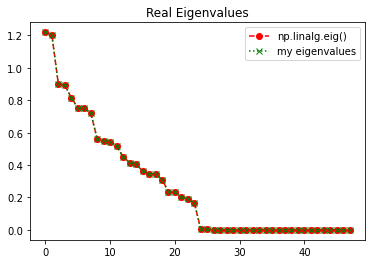

In [34]:
# real symmetric 48x48

source = 'matricmarket/bcsstk01.mtx.gz' 
matrix_class = Matrix

runtest_matrixmarket(source, matrix_class,shift=None)


From Matrix Market: 
matrix source=matricmarket/bcsstk01.mtx.gz, matrix type=<class 'scipy.sparse.coo.coo_matrix'>, shape=(48, 48), data type=float64, max=2472387301.98, min=-109779731.332
is_symmetric={} True
activiating tridigonal: True

 ------------ Processing eigenvalues only ------------ 
>>> QR Iteration with Wilkinson shift


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


Iteration terminates at i=174 with tol=1e-06 reached

 ------------ Checking Eigenvalues ------------

my eigenvalues: [1.22  1.201 0.898 0.893 0.816 0.752 0.75  0.722 0.561 0.551 0.544 0.516 0.452 0.415 0.407 0.362 0.346 0.346 0.31  0.236 0.234 0.2   0.193 0.167 0.003 0.003 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
np.linalg.eig:  [1.22  1.201 0.898 0.893 0.816 0.752 0.75  0.722 0.561 0.551 0.544 0.516 0.452 0.415 0.407 0.362 0.346 0.346 0.31  0.236 0.234 0.2   0.193 0.167 0.003 0.003 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]

np.linalg.eig and my eigenvalues close? True 

float64


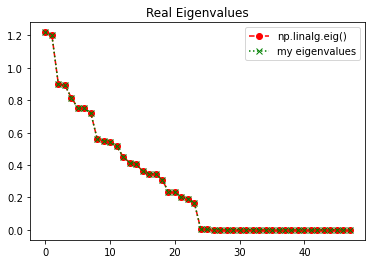

In [38]:
# real symmetric 48x48

source = 'matricmarket/bcsstk01.mtx.gz' 
matrix_class = Matrix

runtest_matrixmarket(source, matrix_class,shift='Wilkinson')


<br>

**Observation**
- General QR iteration without shift seems to be working for small real symmetric matrix
- QR iteration with Wilkinson shift seems to be working for small real symmetric matrix
- Similar convergence rate... 
<br>


From Matrix Market: 
matrix source=matricmarket/ck104.mtx.gz, matrix type=<class 'scipy.sparse.coo.coo_matrix'>, shape=(104, 104), data type=float64, max=4.7481454523109, min=-2.6168329561089
is_symmetric={} False
activiating tridigonal: False

 ------------ Processing eigenvalues only ------------ 
>>> QR Iteration WITHOUT shift


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


Iteration terminates at i=2982 with tol=1e-06 reached

 ------------ Checking Eigenvalues ------------

my eigenvalues: [1.159+0.j    1.159-0.j    0.336+0.j    0.336+0.j    0.299+0.j    0.299+0.j    0.297+0.j    0.297+0.j    0.252+0.j    0.252+0.j    0.24 +0.j    0.24 -0.j    0.24 +0.j    0.24 -0.j    0.228+0.j    0.228-0.j    0.216+0.j    0.216+0.j    0.211+0.j    0.211-0.j    0.211+0.j    0.211-0.j    0.204+0.j
 0.204+0.j    0.198+0.j    0.198+0.j    0.194+0.j    0.194-0.j    0.194+0.j    0.194-0.j    0.189+0.j    0.189+0.j    0.175+0.j    0.175-0.j    0.172+0.j    0.172+0.j    0.172+0.j    0.172+0.j    0.167+0.j    0.167+0.j    0.148+0.j    0.148+0.j    0.145+0.j    0.145+0.j    0.145+0.j    0.145+0.j
 0.142+0.j    0.142-0.j    0.119+0.j    0.119+0.j    0.117+0.j    0.117+0.j    0.117+0.j    0.117+0.j    0.116+0.j    0.116+0.j    0.089+0.j    0.089+0.j    0.089+0.j    0.089+0.j    0.089+0.j    0.089-0.j    0.089+0.j    0.089-0.j    0.063+0.j    0.063+0.j    0.063+0.j    0.063+0.j   

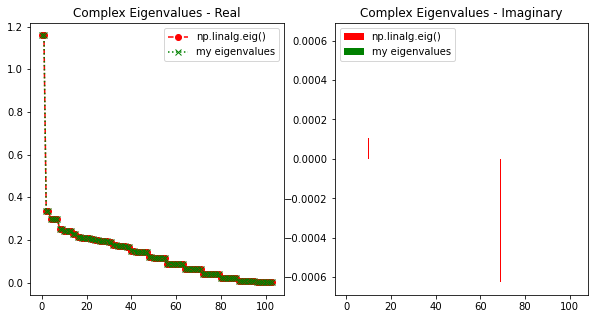

In [35]:
MAX_ITER = 10000 # increased max iteration

# real unsymmetric matrix 104x104 - WIHTOUT SHIFT

source = 'matricmarket/ck104.mtx.gz' 
matrix_class = Matrix

runtest_matrixmarket(source, matrix_class,shift=None)


From Matrix Market: 
matrix source=matricmarket/ck104.mtx.gz, matrix type=<class 'scipy.sparse.coo.coo_matrix'>, shape=(104, 104), data type=float64, max=4.7481454523109, min=-2.6168329561089
is_symmetric={} False
activiating tridigonal: False

 ------------ Processing eigenvalues only ------------ 
>>> QR Iteration with Wilkinson shift


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


max_iter=10000 reached, max error=0.0029218219274107005 vs tol=1e-06; index of non-convergence=[[67], [69]]

 ------------ Checking Eigenvalues ------------

my eigenvalues: [1.159+0.j    1.159-0.j    0.336+0.j    0.336+0.j    0.299+0.j    0.299+0.j    0.297+0.j    0.297+0.j    0.252+0.j    0.252+0.j    0.24 +0.j    0.24 -0.j    0.24 +0.j    0.24 -0.j    0.228+0.j    0.228-0.j    0.216+0.j    0.216+0.j    0.211+0.j    0.211-0.j    0.211+0.j    0.211-0.j    0.204+0.j
 0.204+0.j    0.198+0.j    0.198+0.j    0.194+0.j    0.194-0.j    0.194+0.j    0.194-0.j    0.189+0.j    0.189+0.j    0.175+0.j    0.175+0.j    0.172+0.j    0.172+0.j    0.172+0.j    0.172+0.j    0.167+0.j    0.167+0.j    0.148+0.j    0.148+0.j    0.145+0.j    0.145+0.j    0.145+0.j    0.145+0.j
 0.142+0.j    0.142+0.j    0.119+0.j    0.119+0.j    0.117+0.j    0.117+0.j    0.117+0.j    0.116+0.j    0.116+0.j    0.101+0.j    0.089+0.j    0.089+0.j    0.089+0.j    0.089+0.j    0.089+0.j    0.089-0.j    0.089+0.j    0.089-0.j 

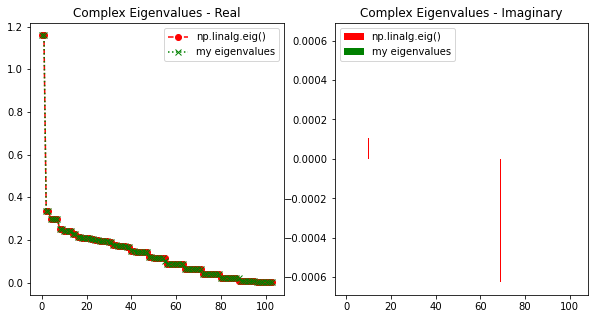

In [36]:
# real unsymmetric matrix 104x104 - WILKINSON SHIFT

source = 'matricmarket/ck104.mtx.gz' 
matrix_class = Matrix

runtest_matrixmarket(source, matrix_class,shift='Wilkinson')


<br>

**Observation**
- General QR iteration without shift seems to be working for real unsymmetric matrix
- However, applying Wilkinson's shift seems to converge slower than without shift... **WHY??**

<br>


From Matrix Market: 
matrix source=matricmarket/qc324.mtx.gz, matrix type=<class 'scipy.sparse.coo.coo_matrix'>, shape=(324, 324), data type=complex128, max=(1.4957127687965-0.087585823232133j), min=(-0.40837438550439-0.017204228197979j)
is_symmetric={} True
activiating tridigonal: True

 ------------ Processing eigenvalues only ------------ 
>>> QR Iteration WITHOUT shift
max_iter=10000 reached, max error=0.034575504317016725 vs tol=1e-06; index of non-convergence=[[52], [54], [142], [144], [178], [180], [268], [270], [271]]

 ------------ Checking Eigenvalues ------------

my eigenvalues: [ 1.014-0.063j  0.859-0.064j  0.786-0.072j  0.741-0.07j   0.632-0.069j  0.628-0.06j   0.548-0.058j  0.519-0.048j  0.48 -0.056j  0.41 -0.042j  0.401-0.048j  0.354-0.054j  0.324-0.039j  0.312-0.042j  0.305-0.041j  0.275-0.039j  0.248-0.034j  0.235-0.039j  0.218-0.038j  0.203-0.033j  0.2  -0.038j
  0.193-0.039j  0.189-0.036j  0.184-0.026j  0.182-0.028j  0.17 -0.027j  0.168-0.03j   0.167-0.031j  0.164-0

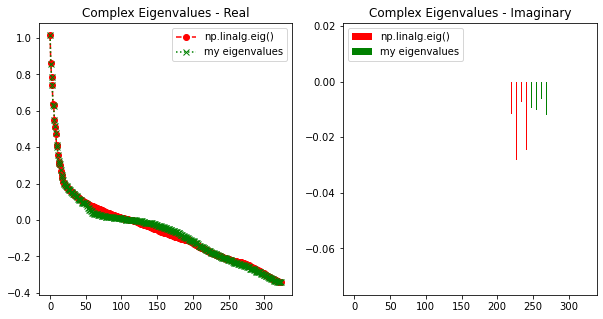

In [37]:
MAX_ITER = 10000

# complex symmetric matrix - WIHTOUT SHIFT

source = 'matricmarket/qc324.mtx.gz'
matrix_class = Matrix

runtest_matrixmarket(source, matrix_class,shift=None)


<br>

**Observation**
- General QR iteration without shift seems to be working for complex symmetric matrix

<br>


From Matrix Market: 
matrix source=matricmarket/qc324.mtx.gz, matrix type=<class 'scipy.sparse.coo.coo_matrix'>, shape=(324, 324), data type=complex128, max=(1.4957127687965-0.087585823232133j), min=(-0.40837438550439-0.017204228197979j)
is_symmetric={} True
activiating tridigonal: True

 ------------ Processing eigenvalues only ------------ 
>>> QR Iteration with Wilkinson shift
Iteration terminates at i=9047 with tol=1e-06 reached

 ------------ Checking Eigenvalues ------------

my eigenvalues: [ 1.013-0.063j  0.859-0.064j  0.788-0.067j  0.741-0.071j  0.635-0.061j  0.634-0.072j  0.547-0.058j  0.517-0.061j  0.471-0.053j  0.414-0.047j  0.402-0.046j  0.357-0.035j  0.317-0.036j  0.309-0.038j  0.304-0.044j  0.265-0.04j   0.243-0.042j  0.241-0.037j  0.213-0.034j  0.206-0.031j  0.202-0.033j
  0.196-0.037j  0.191-0.036j  0.188-0.03j   0.184-0.039j  0.178-0.04j   0.171-0.031j  0.168-0.028j  0.164-0.031j  0.158-0.036j  0.156-0.024j  0.152-0.026j  0.147-0.03j   0.142-0.022j  0.141-0.031j  0.14

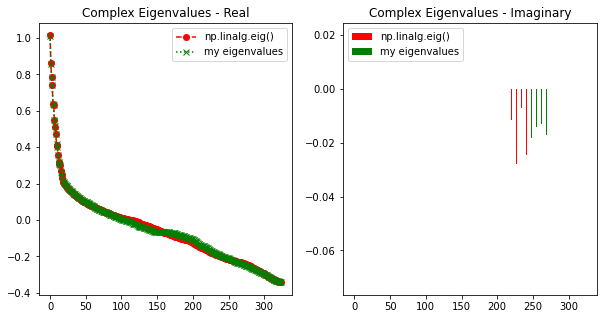

In [39]:
MAX_ITER = 10000

# complex symmetric matrix - WILKINSON SHIFT

source = 'matricmarket/qc324.mtx.gz'
matrix_class = Matrix
runtest_matrixmarket(source, matrix_class,shift='Wilkinson')


<br>

**Observation**
- QR iteration with Wilkinson's shift seems to be working for complex symmetric matrix
- Slightly better convergence than the general method without shift
- Max iteration increased to 1e4

<br>



From Matrix Market: 
matrix source=matricmarket/mhd1280a.mtx.gz, matrix type=<class 'scipy.sparse.coo.coo_matrix'>, shape=(1280, 1280), data type=complex128, max=(74619.3808+3.84011238e-11j), min=(-15906.7974-2.73633283e-07j)
is_symmetric={} False
activiating tridigonal: False

 ------------ Processing eigenvalues only ------------ 
>>> QR Iteration WITHOUT shift
Iteration terminates at i=33607 with tol=1e-06 reached

 ------------ Checking Eigenvalues ------------

my eigenvalues: [ 0.-0.j     0.-0.j     0.-0.j    ... -0.-0.003j -0.-0.003j -0.+0.003j]
np.linalg.eig:  [ 0.+0.j     0.+0.j     0.+0.j    ... -0.-0.003j -0.-0.003j -0.+0.003j]

np.linalg.eig and my eigenvalues close? False 

my eigenvalues - np.linalg.eig =
 [0.-0.j 0.-0.j 0.-0.j ... 0.+0.j 0.+0.j 0.-0.j] 

max abs diff =  0.00017325703855534271 



complex128


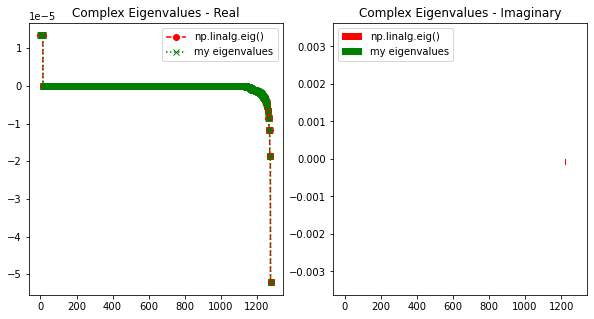

In [40]:
MAX_ITER = 100000

# Complex unsymmetric
source = 'matricmarket/mhd1280a.mtx.gz'
matrix_class = Matrix
runtest_matrixmarket(source, matrix_class,shift=None)


From Matrix Market: 
matrix source=matricmarket/mhd1280a.mtx.gz, matrix type=<class 'scipy.sparse.coo.coo_matrix'>, shape=(1280, 1280), data type=complex128, max=(74619.3808+3.84011238e-11j), min=(-15906.7974-2.73633283e-07j)
is_symmetric={} False
activiating tridigonal: False

 ------------ Processing eigenvalues only ------------ 
>>> QR Iteration with Wilkinson shift
Iteration terminates at i=13234 with tol=1e-06 reached

 ------------ Checking Eigenvalues ------------

my eigenvalues: [ 0.-0.j     0.-0.j     0.+0.j    ... -0.-0.003j -0.-0.003j -0.+0.003j]
np.linalg.eig:  [ 0.+0.j     0.+0.j     0.+0.j    ... -0.-0.003j -0.-0.003j -0.+0.003j]

np.linalg.eig and my eigenvalues close? False 

my eigenvalues - np.linalg.eig =
 [ 0.-0.j  0.-0.j  0.+0.j ...  0.+0.j -0.+0.j -0.-0.j] 

max abs diff =  0.00015237568085155927 



complex128


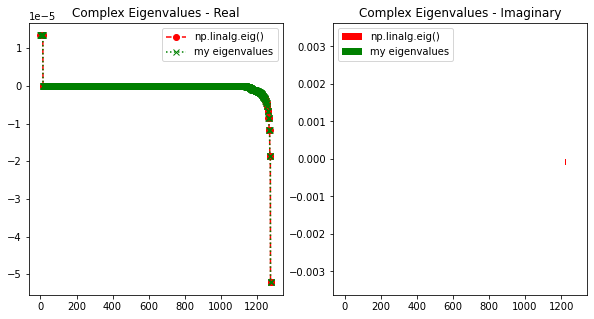

In [41]:
MAX_ITER = 100000

# Complex unsymmetric
source = 'matricmarket/mhd1280a.mtx.gz'
matrix_class = Matrix
runtest_matrixmarket(source, matrix_class,shift='Wilkinson')


<br>

**Observation**
- Increased max iteration number to 1e5
- General QR iteration without shift seems to be working for complex unsymmetric matrix
- This demonstrates that QR iteration with Wilkinson shift indeed converges faster

<br>


--------------------------------------------
# Checklist / To-Dos:

#### Option 1

*General complex matrices with transformation to Hessenberg form*
- Hessenberg form via Housholder Tranformation  ***<span style="color:blue">\[Done\]</span>***
- QR Iteration with Givens Rotation ***<span style="color:blue">\[Done\]</span>***
- Test for convergence ***<span style="color:blue">\[Done\]</span>***
- Modify Householder to accommodate for complex matrices ***<span style="color:blue">\[Done\]</span>*** 
- Modify Givens to accommodate for complex matrices ***<span style="color:blue">\[Done\]</span>*** 
- Diagonal blocks for real matrix with complex conjugate eigenvalues ***<span style="color:blue">\[Done\]</span>*** 
- Use Wilkinson shifts to accelerate convergence ***<span style="color:blue">\[Done\]</span>***
- Investigate convergence - comparison visualization ***<span style="color:blue">\[Done\]</span>***

- Compute not only eigenvalues but also eigenvectors  ***<span style="color:blue">\[Done\]</span>***
- Apply your program to several suitable matrices from the Matrix Market. Use suitable library functions for reading the matrices. ***<span style="color:blue">\[Done\]</span>***

- Object-oriented programming: is it possible to implement algorithm 1.4.14 in a way, that H is either Hessenberg or tridiagonal, either real or complex, but encapsulate the differences inside the QR-decompositions applied in every step _ element-wise application (special case of tridiagonal) ***<span style="color:blue">\[Done\]</span>***

--------------------------------------------
<br>

#### Option 2 
*General real matrices with transformation to Hessenberg form and double shifts for complex eigenvalues*

- Use double shifts to avoid complex arithmetic _ Matrix multiplication ***<span style="color:blue">\[Done\]</span>*** 
- "Bulge-chasing" for element-wise computation **<span style="color:red">#NOT IMPLEMENTED</span>** 

<br> 


#### Option 3  
*Symmetric real matrices with transformation to tridiagonal form with optimized storage*

- Use deflation when the subdiagonal element in the last row is sufficiently small (implementation may be hard if not option 3) 
- Use deflation**, if any other subdiagonal element is small (seems very hard) 
- Add SVD capability to option 3 

<br>

--------------------------------------------

### Additional Considerations

- Well-chosen tests for correctness 
- Investigation into convergence 
- Write very well structured code 
- Well-prepared jupyter notebooks with code, accompanying text, and results 
--------------------------------------------

